In [1]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, Birch, MeanShift, estimate_bandwidth, DBSCAN, AgglomerativeClustering
from sklearn import metrics
from sklearn.impute import KNNImputer
from math import floor
import seaborn as sns
from sklearn.manifold import MDS

import os

# Establecer la variable de entorno OMP_NUM_THREADS
os.environ["OMP_NUM_THREADS"] = "5"  # Puedes ajustar el número de hilos según tu configuración

In [2]:
### FUNCIONES DEFINIDAS ###
#peso = 'ponde'

# Función de normalización
def norm_to_zero_one(df):
    return (df - df.min()) * 1.0 / (df.max() - df.min())

# Imputamos por vecinos más cercanos. También aplicamos normalización
def imputar_valores_perdidos(datos):
    imputer = KNNImputer(n_neighbors=3)
    datos_norm = datos.apply(norm_to_zero_one)
    datos_imputados_array = imputer.fit_transform(datos_norm)
    datos_norm2 = pd.DataFrame(datos_imputados_array, columns = datos.columns)
    datos = datos_norm2
    return datos

def eliminar_outliers(X):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    X = X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]
    return X

### ALGORITMOS ###
def kmeans(X_normal, subset, n_clusters_arg=4, n_init_arg=5, random_state_arg=123456):
    print('----- Ejecutando k-Means',end='')
    k_means = KMeans(init='k-means++', n_clusters=n_clusters_arg, n_init=n_init_arg, random_state=random_state_arg)
    t = time.time()
    cluster_predict = k_means.fit_predict(X_normal, subset['ponde']) #se usa peso para cada objeto (factor de elevación)
    tiempo = time.time() - t
    print(": {:.2f} segundos, ".format(tiempo), end='')
    return tiempo, k_means, cluster_predict

def birch(arg_branching_factor, arg_threshold, X_normal):
    print('----- Ejecutando Birch, branching factor: ' + str(arg_branching_factor) + ', threshold: ' + str(arg_threshold), end='') # -----
    #El branching factor (factor de ramificación) controla el número máximo de subclusters que un nodo interno puede tener antes de dividirse en dos.
    #El threshold es un umbral que controla la compactación de los subclusters en el proceso de construcción del árbol.
    
    #Medimos el tiempo
    t = time.time()
    # Ejecutamos el algoritmo, asignamos el num de clasters
    birch = Birch(branching_factor=arg_branching_factor, threshold=arg_threshold, n_clusters=4)

    cluster_predict = birch.fit_predict(X_normal)
    tiempo = time.time() - t
    #Mostramos resultados
    print(": {:.2f} segundos, ".format(tiempo), end='')
    
    return tiempo, birch, cluster_predict


def meanshift(arg_bandwidth, X_normal):
    print('----- Ejecutando meanshift con radio=' + str(arg_bandwidth), end='')

    #Tomamos tiempos
    t = time.time()
    # Ejecuto el algoritmo y asigno los clusters
    mshift = MeanShift(bandwidth=arg_bandwidth)

    cluster_predict = mshift.fit_predict(X_normal)
    tiempo = time.time() - t
    #Pinto resultados
    print(": {:.2f} segundos, ".format(tiempo), end='')
    
    return tiempo, mshift, cluster_predict


def dbscan(arg_eps, arg_min_samples, X_normal):
    print('----- Ejecutando DBSCAN: minPts=' + str(arg_min_samples) + ', eps=' + str(arg_eps), end='')

    #Tomamos tiempos
    t = time.time()
    # Ejecuto el algoritmo y asigno los clusters
    dbscan = DBSCAN(eps=arg_eps, min_samples=arg_min_samples)

    cluster_predict = dbscan.fit_predict(X_normal)
    tiempo = time.time() - t
    #Pinto resultados
    print(": {:.2f} segundos, ".format(tiempo), end='')
    
    return tiempo, dbscan, cluster_predict

def single_linkage(X_normal, subset, n_clusters_arg=4):
    print('----- Ejecutando Single Linkage Hierarchical Clustering', end='')

    # Tomamos tiempos
    t = time.time()

    # Ejecutamos el algoritmo y asignamos los clusters
    single_linkage = AgglomerativeClustering(n_clusters=n_clusters_arg, linkage='single')
    cluster_predict = single_linkage.fit_predict(X_normal, subset['ponde'])  # se usa peso para cada objeto (factor de elevación)

    tiempo = time.time() - t

    # Pintamos resultados
    print(": {:.2f} segundos, ".format(tiempo), end='')

    return tiempo, single_linkage, cluster_predict


### MEDIDAS
#índice de Calinski-Harabasz
def CH_score(X_normal, cluster_predict):
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    return metric_CH


# Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
# Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
def SC_score(X_normal, cluster_predict):
    muestra_silhouette = 0.2 if (len(X) > 10000) else 1.0
    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhouette*len(X)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    return metric_SC

def tamano_clusters(clusters):
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()
    size = size.sort_index()
    tabla_tam_clusters = []
    
    for i,c in enumerate(size):
        print('%s: %5d (%5.2f%%)' % (i,c,100*c/len(clusters)))
        tabla_tam_clusters.append(i)
        
    return tabla_tam_clusters, size

def tamano_clusters_tabla(clusters):
    print("Tamaño de cada cluster:")
    size = clusters['cluster'].value_counts().sort_index()
    
    tabla_tam_clusters = []
    
    for i, c in enumerate(size):
        print('%s: %5d (%5.2f%%)' % (i, c, 100 * c / len(clusters)))
        tabla_tam_clusters.append({'cluster': i, 'tamaño': c})
        
    return tabla_tam_clusters, size

### VISUALIZACIÓN
def heatmap(k_means):
    print("---------- Heatmap de centroides...")
    centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
    centers_desnormal = centers.copy()

    # se convierten los centros a los rangos originales antes de normalizar
    for var in list(centers):
        centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())

    plt.figure()
    centers.index += 1
    plt.figure()
    hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
    hm.set_ylim(len(centers),0)
    hm.figure.set_size_inches(15,15)
    hm.figure.savefig("centroides.pdf")
    centers.index -= 1
    
def scatter(X_kmeans, colors):
    print("---------- Scatter matrix...")
    plt.figure()
    sns.set()
    variables = list(X_kmeans)
    variables.remove('cluster')
    X_kmeans['cluster'] += 1
    sns_plot = sns.pairplot(X_kmeans, vars=variables, hue="cluster", palette=colors, plot_kws={"s": 25}, diag_kind="hist") #en hue indicamos que la columna 'cluster' define los colores
    X_kmeans['cluster'] -= 1
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03)
    sns_plot.fig.set_size_inches(15,15)
    #sns_plot.savefig("C:/Users/monic/Documents/DGIIM5/IN/practicas/p2/scatter.pdf") #Me da PermisionError
    plt.show()
    
def calcular_centros(algoritmo, X, k_means, cluster_predict):
    if algoritmo == 'kmeans':
        centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
        centers_desnormal = centers.copy()

        # se convierten los centros a los rangos originales antes de normalizar
        for var in list(centers):
            centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())
        
    return centers, centers_desnormal
    
    
def MDS_plot(centers, size):
    print("---------- MDS...")
    X_kmeans = pd.concat([X, clusters], axis=1)
    k = len(size)
    colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
    
    mds = MDS()
    centers_mds = mds.fit_transform(centers)
    fig=plt.figure(4)
    
    plt.scatter(centers_mds[:,0], centers_mds[:,1], s=size*10, alpha=0.75, c=colors)
    for i in range(k):
        plt.annotate(str(i+1),xy=centers_mds[i],fontsize=18,va='center',ha='center')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    fig.set_size_inches(15,15)

    nombre = "mds.png"
    plt.savefig(nombre)

    
### TABLAS
def tabla_medidas_formato(l):
    # Cabecera de la tabla para pasarla directamente a latex
    print("\\begin{table}[H]")
    print("\centering")
    print("\caption{Resultados medidas}")
    print("\label{tab:medidas_casoX}")
    print("\\begin{tabular}{llrrrrr}")
    print("\\toprule")
    print(" Algoritmo & Tiempo (s)  & Calinski-Harabasz & Silhouette & Número de clusters \\\\")
    print("\midrule")

    # Contenido de la tabla
    for s in l:
        print(s)
    
    # Cierre de la tabla
    print("\\bottomrule")
    print("\end{tabular}")
    print("\end{table}")
    
def tabla_parametros_formato(l, algoritmo):
    # Cabecera de la tabla para pasarla directamente a latex
    print("\\begin{table}[H]")
    print("\centering")
    print("\caption{Resultados cambio de parámetros}")
    print("\label{tab:param_algoritmo}")
    print("\\begin{tabular}{llrrrrr}")
    print("\\toprule")
    if algoritmo=="dbscan":
        print(" Algoritmo & eps & minPts & Tiempo (s)  & Calinski-Harabasz & Silhouette & Número de clusters \\\\")
    elif algoritmo=="birch":
        print(" Algoritmo & branding factor & threshold & Tiempo (s) & Silhouette & Calinski-Harabasz & Número de clusters \\\\")
    print("\midrule")

    # Contenido de la tabla
    for s in l:
        print(s)
    
    # Cierre de la tabla
    print("\\bottomrule")
    print("\end{tabular}")
    print("\end{table}")

In [3]:
### CASO DE ESTUDIO 1A
datos = pd.read_csv('03_Datos_noviembre_2023_num.csv')
peso = 'ponde'
tabla_medidas=[]

#Imputamos los valores perdidos
datos=imputar_valores_perdidos(datos)

# Seleccionar casos, filtrando por nivel de educación
subset = datos.loc[(datos['educacion_r']<=0.5)] #Educación de hasta "Segundo grado, segundo ciclo"

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"p7": "ideologia", "p10": "oido_sobre_guerra", "p11_1": "israel_justificable", "p11_2": "hamas_justificable", "p13_2": "respuesta_ONU"})
usadas = ['ideologia', 'oido_sobre_guerra','israel_justificable', 'hamas_justificable', 'respuesta_ONU']
#print(subset[usadas])


n_var = len(usadas)
X = subset[usadas]

#eliminamos outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
X=eliminar_outliers(X)

# normalizamos
X_normal = X.apply(norm_to_zero_one)



### Ejecutamos algoritmos
algoritmos = ['kmeans', 'birch', 'meanshift', 'dbscan', 'single_linkage']
results_df = pd.DataFrame(columns=['Algoritmo', 'Tiempo (s)', 'Calinski-Harabasz', 'Silhouette', 'Número de clusters']) #Para la tabla

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        tiempo, kmeans_resultado, cluster_predict = kmeans(X_normal, subset)
        cluster_kmeans=cluster_predict
    elif algoritmos[i] == 'birch':
        tiempo, birch_resultado, cluster_predict = birch(15, 0.1, X_normal)
    elif algoritmos[i] == 'meanshift':
        bw = estimate_bandwidth(X_normal, quantile=0.05) #Utilizo el 5% de los datos para estimar el radiod
        #bw = estimate_bandwidth(X_normal)
        tiempo, meanshift_resultado, cluster_predict = meanshift(bw, X_normal)
    elif algoritmos[i] == 'dbscan':
        tiempo, dbscan_resultado, cluster_predict = dbscan(0.126, 15, X_normal)
    elif algoritmos[i] == 'single_linkage':
        tiempo, single_linkage_resultado, cluster_predict = single_linkage(X_normal, subset)
        
    try:
        ch=0
        sc=0
        print("\n\nMedidas\n\n")
        ch = CH_score(X_normal, cluster_predict)
        sc = SC_score(X_normal, cluster_predict)
    except:
        print("\n\nNo hay medidas :(\n\n")
        
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    #print(size)
    tamanio_cluster=len(tamano)
    if algoritmos[i]=='kmeans':
        tabla_clusters=tamano_clusters_tabla(clusters)
    
    # Generar tablita
    s = algoritmos[i]  + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(ch) + " & "
    s += "{:.5f}".format(sc) + " & "
    s += "{:.0f}".format(len(size)) + " \\\\"

    tabla_medidas.append(s)
    
    results_df = pd.concat([results_df, pd.DataFrame({
        'Algoritmo': [algoritmos[i]],
        'Tiempo (s)': [tiempo],
        'Calinski-Harabasz': [ch if 'ch' in locals() else None],
        'Silhouette': [sc if 'sc' in locals() else None],
        'Número de clusters': [tamanio_cluster]
    })], ignore_index=True)

#Imprimir tablita
#print(results_df)

tabla_medidas_formato(tabla_medidas)

----- Ejecutando k-Means: 0.10 segundos, 

Medidas


Calinski-Harabasz Index: 281.540, Silhouette Coefficient: 0.22860
Tamaño de cada cluster:
0:   292 (26.72%)
1:   292 (26.72%)
2:   245 (22.42%)
3:   264 (24.15%)
Tamaño de cada cluster:
0:   292 (26.72%)
1:   292 (26.72%)
2:   245 (22.42%)
3:   264 (24.15%)
----- Ejecutando Birch, branching factor: 15, threshold: 0.1

C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\monic\AppData\Local\Temp\ipykernel_7648\277289800.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


: 0.09 segundos, 

Medidas


Calinski-Harabasz Index: 182.466, Silhouette Coefficient: 0.12856
Tamaño de cada cluster:
0:   306 (28.00%)
1:   390 (35.68%)
2:   196 (17.93%)
3:   201 (18.39%)
----- Ejecutando meanshift con radio=0.4400923016350677: 1.87 segundos, 

Medidas


Calinski-Harabasz Index: 95.582, Silhouette Coefficient: 0.11052
Tamaño de cada cluster:
0:   579 (52.97%)
1:   367 (33.58%)
2:   113 (10.34%)
3:    25 ( 2.29%)
4:     9 ( 0.82%)
----- Ejecutando DBSCAN: minPts=15, eps=0.126: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 5.802, Silhouette Coefficient: -0.31693
Tamaño de cada cluster:
0:  1033 (94.51%)
1:    23 ( 2.10%)
2:    16 ( 1.46%)
3:    21 ( 1.92%)
----- Ejecutando Single Linkage Hierarchical Clustering: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 77.208, Silhouette Coefficient: 0.11784
Tamaño de cada cluster:
0:    25 ( 2.29%)
1:   686 (62.76%)
2:   381 (34.86%)
3:     1 ( 0.09%)
\begin{table}[H]
\centering
\caption{Resultados medidas}
\label{ta

----- Ejecutando k-Means: 0.06 segundos, Tamaño de cada cluster:
0:   292 (26.72%)
1:   292 (26.72%)
2:   245 (22.42%)
3:   264 (24.15%)


C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


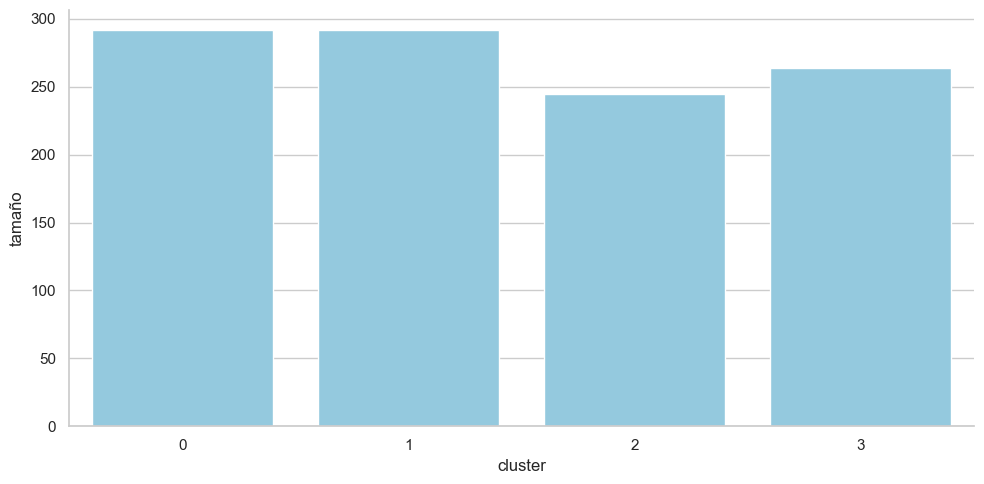

---------- Heatmap de centroides...
---------- Scatter matrix...


<Figure size 640x480 with 0 Axes>

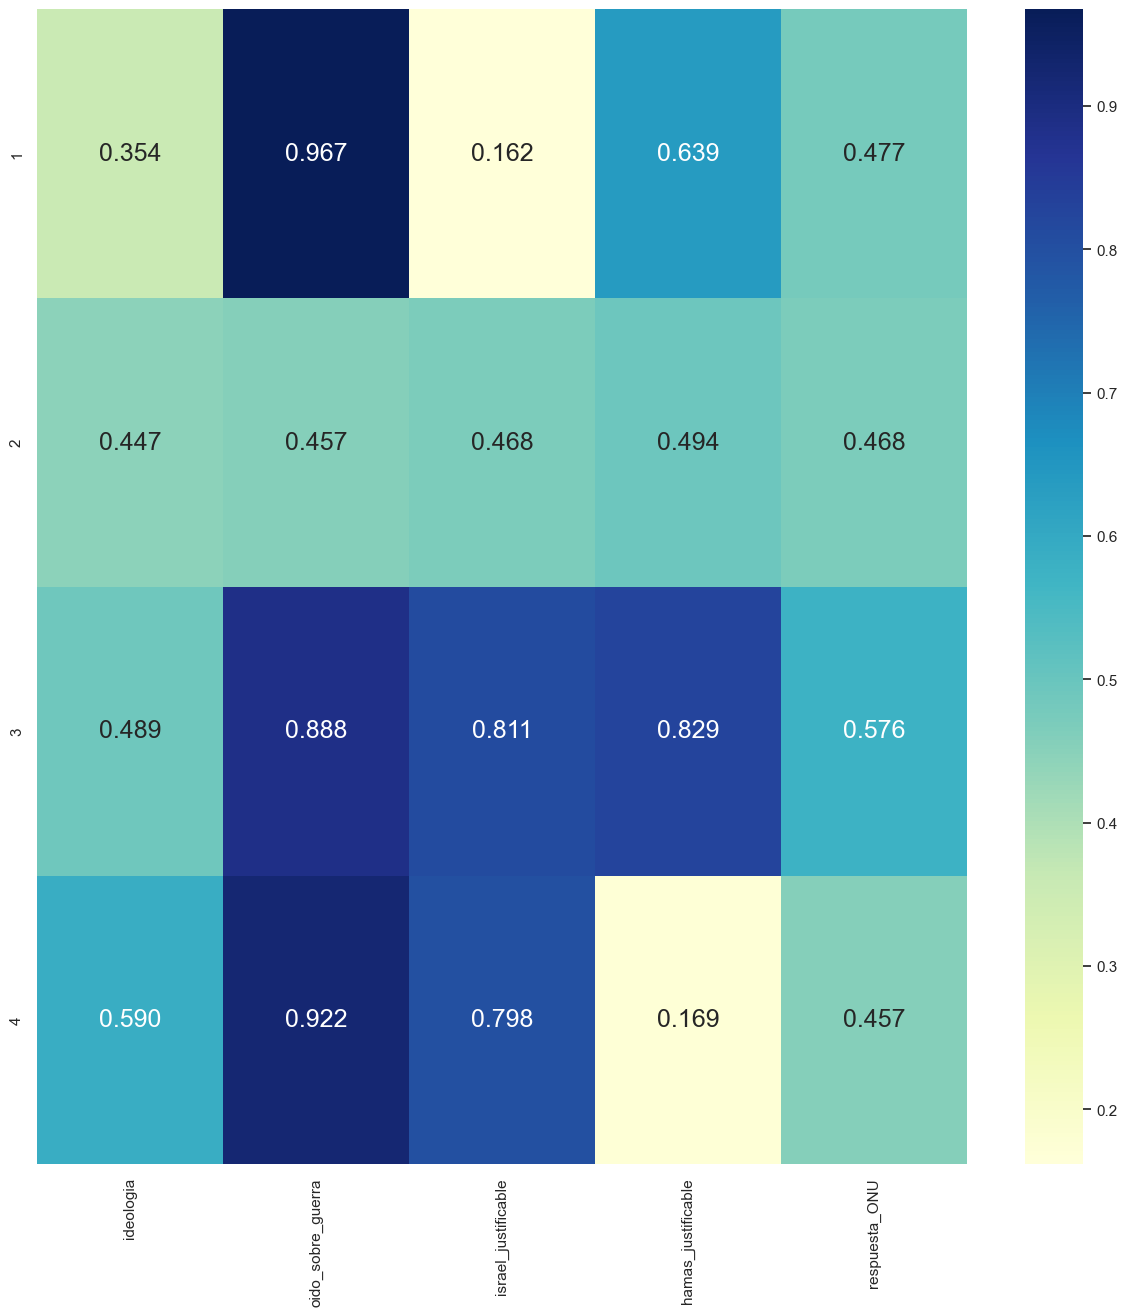

<Figure size 640x480 with 0 Axes>

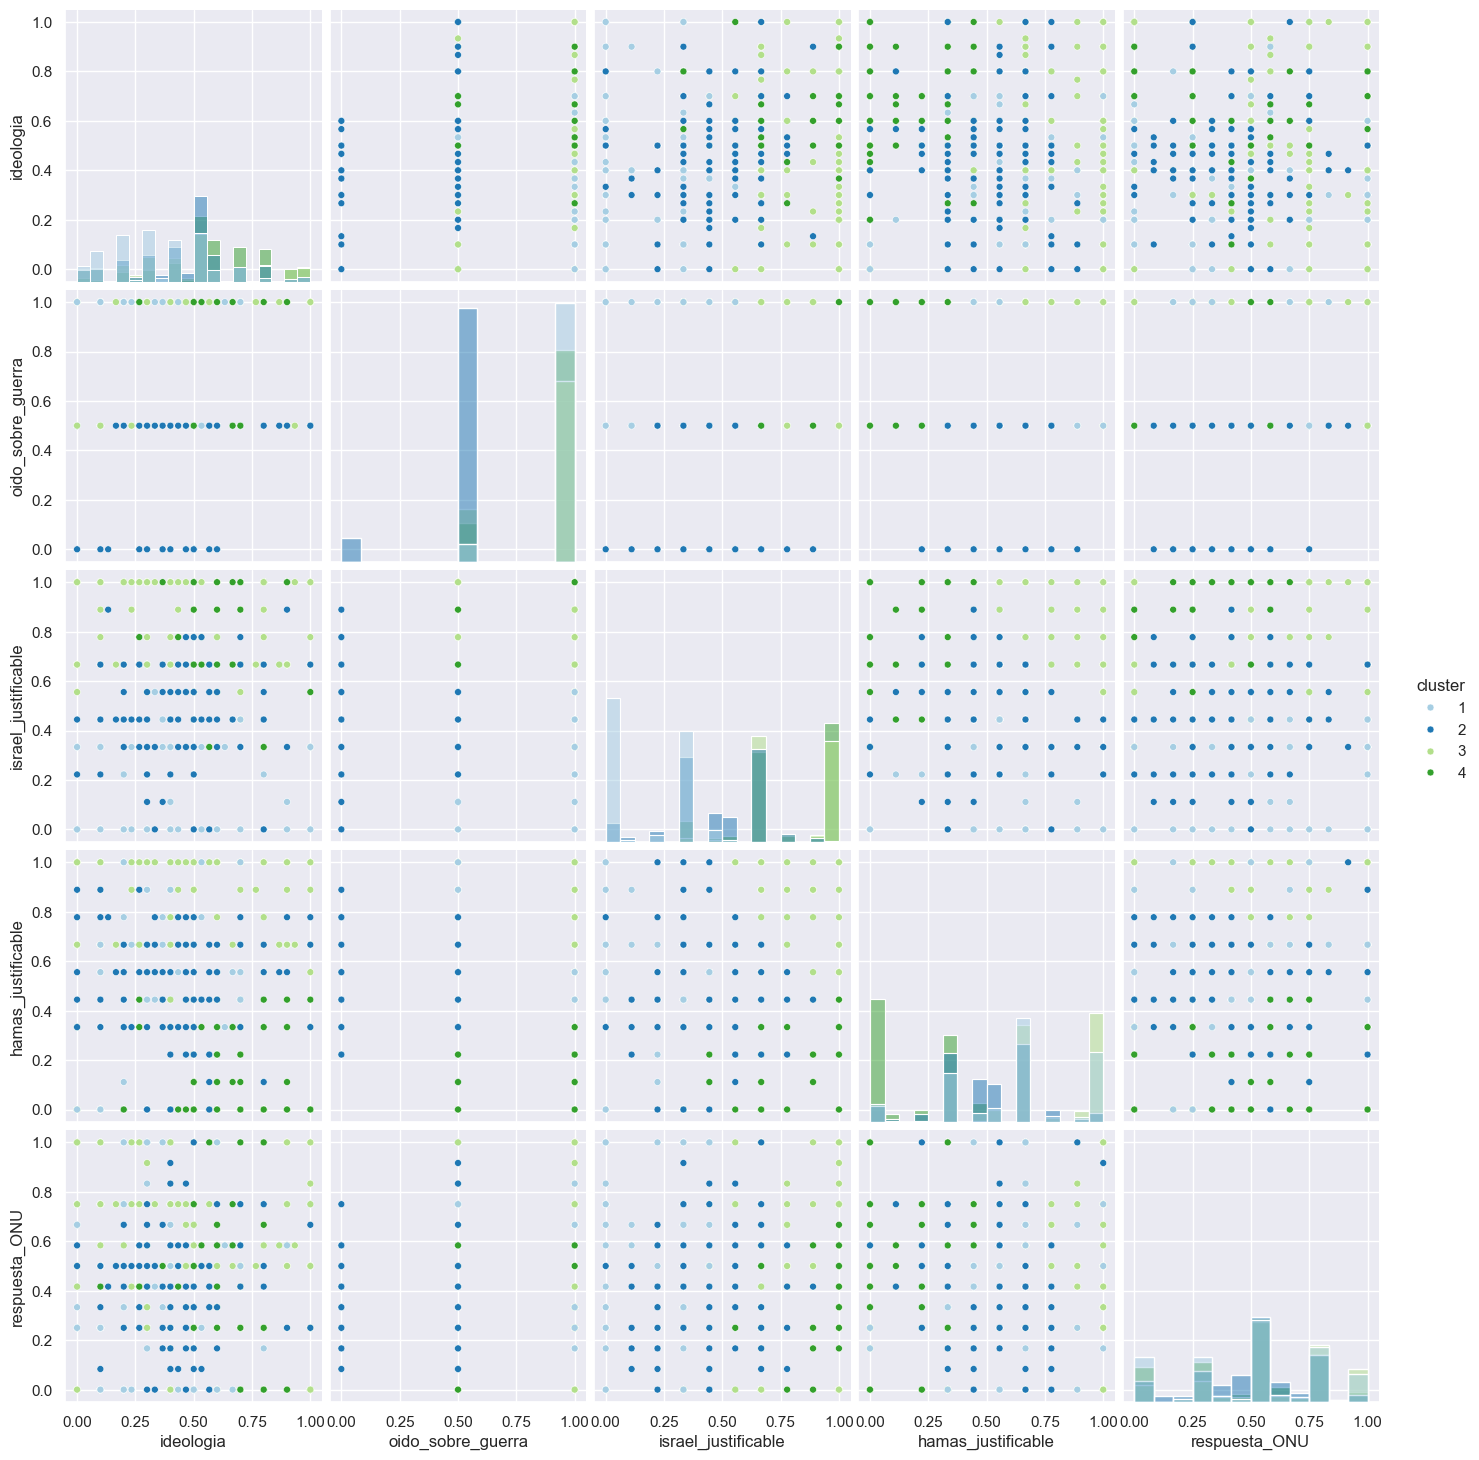

---------- MDS...


C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


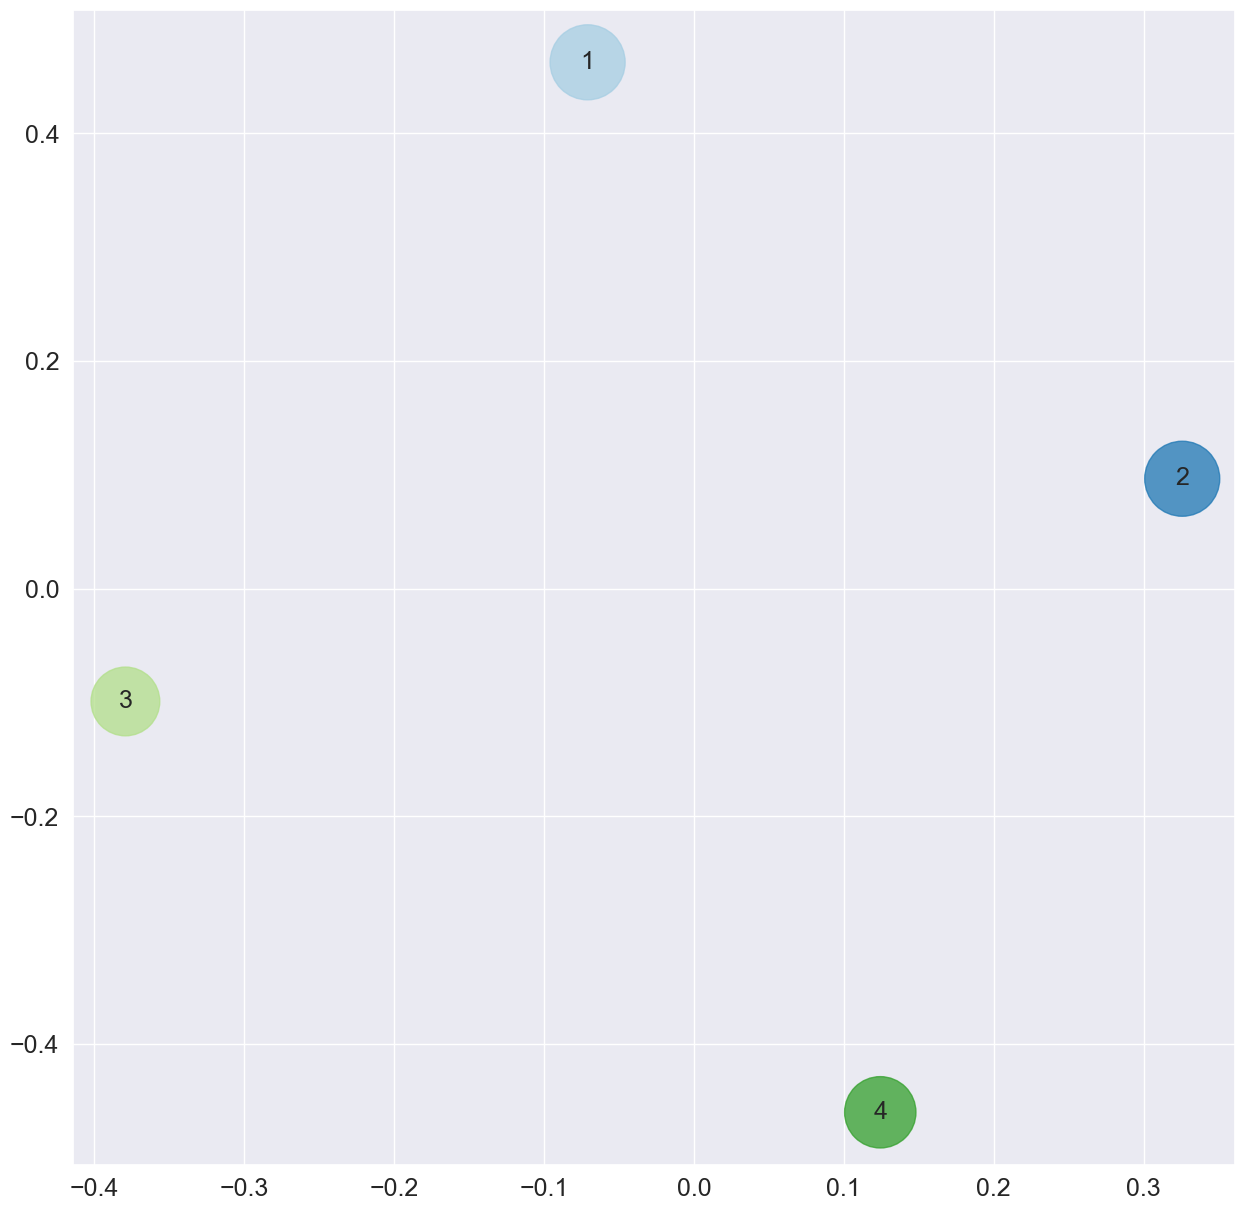

In [4]:
### VISUALIZACIÓN CASO 1A - kmeans
### Ejecutamos algoritmos
algoritmos = ['kmeans']
results_df = pd.DataFrame(columns=['Algoritmo', 'Tiempo (s)', 'Calinski-Harabasz', 'Silhouette', 'Número de clusters']) #Para la tabla

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        tiempo, kmeans_resultado, cluster_predict = kmeans(X_normal, subset)
        cluster_kmeans=cluster_predict
        
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    
    
#1. Gráfico de barras para representar el tamaño de los clusters
tabla_clusters = (
    [{'cluster': 0, 'tamaño': 292},
     {'cluster': 1, 'tamaño': 292},
     {'cluster': 2, 'tamaño': 245},
     {'cluster': 3, 'tamaño': 264}],
    pd.Series({0: 292, 1: 292, 2: 245, 3: 264}, name='count')
)

# Crear un DataFrame a partir de la lista de diccionarios
df = pd.DataFrame(tabla_clusters[0])

# Creamos el gráfico de barras
sns.set(style="whitegrid")
sns.catplot(y="tamaño", x="cluster", data=df, kind="bar", color="skyblue", aspect=2)
plt.show()

#2. Heatmap
heatmap(kmeans_resultado)

#3. Scatter matrix
# se añade la asignación de clusters como columna a X
X_kmeans = pd.concat([X, clusters], axis=1)
k = len(size)
colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
scatter(X_kmeans, colors)

#4. Boxplot
#boxplot(X_kmeans, cluster_kmeans)
#boxplot2(kmeans_resultado, X)

#5. MDS
centers, centers_desnormal = calcular_centros("kmeans", X, kmeans_resultado, cluster_kmeans)
MDS_plot(centers, size)

In [5]:
### CASO DE ESTUDIO 1A: Estudio de parámetros en DBSCAN
datos = pd.read_csv('03_Datos_noviembre_2023_num.csv')
peso = 'ponde'
tabla_parametros=[]

#Imputamos los valores perdidos
datos=imputar_valores_perdidos(datos)

# Seleccionar casos, filtrando por nivel de educación
subset = datos.loc[(datos['educacion_r']<=0.5)] #Educación de hasta "Segundo grado, segundo ciclo"

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"p7": "ideologia", "p10": "oido_sobre_guerra", "p11_1": "israel_justificable", "p11_2": "hamas_justificable", "p13_2": "respuesta_ONU"})
usadas = ['ideologia', 'oido_sobre_guerra','israel_justificable', 'hamas_justificable', 'respuesta_ONU']
#print(subset[usadas])


n_var = len(usadas)
X = subset[usadas]

#eliminamos outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
X=eliminar_outliers(X)

# normalizamos
X_normal = X.apply(norm_to_zero_one)


parametros_minPts=[15, 20, 25, 30, 35]
parametros_eps=[0.120, 0.130, 0.150, 0.170, 0.2]

for i in range(0, len(parametros_minPts)):
    for j in range(0, len(parametros_eps)):
        tiempo, dbscan_resultado, cluster_predict = dbscan(parametros_eps[j], parametros_minPts[i], X_normal)
        
        try:
            print("\n\nMedidas\n\n") 
            ch = CH_score(X_normal, cluster_predict)
            sc = SC_score(X_normal, cluster_predict)
        except:
            print("\n\nNo hay medidas :(\n\n") #Cuando sólo hay 1 cluster, no se pueden sacar medidas 
            
        # se convierte la asignación de clusters a DataFrame
        clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

        tamano, size=tamano_clusters(clusters)
        #print(size)
        tamanio_cluster=len(tamano)
        
        s = "dbscan"  + " & "
        s += "{:.3f}".format(parametros_eps[j]) + " & "
        s += "{:.3f}".format(parametros_minPts[i]) + " & "
        s += "{:.3f}".format(tiempo) + " & "
        s += "{:.3f}".format(sc) + " & "
        s += "{:.5f}".format(ch) + " & "
        s += "{:.0f}".format(len(size)) + " \\\\"
        
        tabla_parametros.append(s)

tabla_parametros_formato(tabla_parametros, "dbscan")

----- Ejecutando DBSCAN: minPts=15, eps=0.12: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 5.802, Silhouette Coefficient: -0.31693
Tamaño de cada cluster:
0:  1033 (94.51%)
1:    23 ( 2.10%)
2:    16 ( 1.46%)
3:    21 ( 1.92%)
----- Ejecutando DBSCAN: minPts=15, eps=0.13: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 6.047, Silhouette Coefficient: -0.31474
Tamaño de cada cluster:
0:  1031 (94.33%)
1:    23 ( 2.10%)
2:    18 ( 1.65%)
3:    21 ( 1.92%)
----- Ejecutando DBSCAN: minPts=15, eps=0.15: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 7.075, Silhouette Coefficient: -0.30942
Tamaño de cada cluster:
0:   989 (90.48%)
1:    23 ( 2.10%)
2:    36 ( 3.29%)
3:    20 ( 1.83%)
4:    25 ( 2.29%)
----- Ejecutando DBSCAN: minPts=15, eps=0.17: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 8.761, Silhouette Coefficient: -0.28589
Tamaño de cada cluster:
0:   964 (88.20%)
1:    28 ( 2.56%)
2:    40 ( 3.66%)
3:    34 ( 3.11%)
4:    27 ( 2.47%)
----- Ejecutando DBSCAN: min

In [6]:
### CASO DE ESTUDIO 1A: Estudio de parámetros en BIRCH
datos = pd.read_csv('03_Datos_noviembre_2023_num.csv')
peso = 'ponde'
tabla_parametros=[]

#Imputamos los valores perdidos
datos=imputar_valores_perdidos(datos)

# Seleccionar casos, filtrando por nivel de educación
subset = datos.loc[(datos['educacion_r']<=0.5)] #Educación de hasta "Segundo grado, segundo ciclo"

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"p7": "ideologia", "p10": "oido_sobre_guerra", "p11_1": "israel_justificable", "p11_2": "hamas_justificable", "p13_2": "respuesta_ONU"})
usadas = ['ideologia', 'oido_sobre_guerra','israel_justificable', 'hamas_justificable', 'respuesta_ONU']
#print(subset[usadas])


n_var = len(usadas)
X = subset[usadas]

#eliminamos outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
X=eliminar_outliers(X)

# normalizamos
X_normal = X.apply(norm_to_zero_one)


parametros_branching_factor=[15, 20, 25, 30, 35]
parametros_threshold=[0.1, 0.12, 0.15, 0.2, 0.25]

for i in range(0, len(parametros_branching_factor)):
    for j in range(0, len(parametros_threshold)):
        tiempo, birch_resultado, cluster_predict = birch(parametros_branching_factor[i], parametros_threshold[j], X_normal)
        
        try:
            print("\n\nMedidas\n\n") 
            ch = CH_score(X_normal, cluster_predict)
            sc = SC_score(X_normal, cluster_predict)
        except:
            print("\n\nNo hay medidas :(\n\n") #Cuando sólo hay 1 cluster, no se pueden sacar medidas 
            
        # se convierte la asignación de clusters a DataFrame
        clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

        tamano, size=tamano_clusters(clusters)
        #print(size)
        tamanio_cluster=len(tamano)
        
        s = "birch"  + " & "
        s += "{:.3f}".format(parametros_branching_factor[i]) + " & "
        s += "{:.3f}".format(parametros_threshold[j]) + " & "
        s += "{:.3f}".format(tiempo) + " & "
        s += "{:.3f}".format(sc) + " & "
        s += "{:.5f}".format(ch) + " & "
        s += "{:.0f}".format(len(size)) + " \\\\"
        
        tabla_parametros.append(s)
s
tabla_parametros_formato(tabla_parametros, "birch")

----- Ejecutando Birch, branching factor: 15, threshold: 0.1: 0.09 segundos, 

Medidas


Calinski-Harabasz Index: 182.466, Silhouette Coefficient: 0.12856
Tamaño de cada cluster:
0:   306 (28.00%)
1:   390 (35.68%)
2:   196 (17.93%)
3:   201 (18.39%)
----- Ejecutando Birch, branching factor: 15, threshold: 0.12: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 215.461, Silhouette Coefficient: 0.16763
Tamaño de cada cluster:
0:   260 (23.79%)
1:   429 (39.25%)
2:   161 (14.73%)
3:   243 (22.23%)
----- Ejecutando Birch, branching factor: 15, threshold: 0.15: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 205.239, Silhouette Coefficient: 0.16286
Tamaño de cada cluster:
0:   360 (32.94%)
1:   304 (27.81%)
2:   239 (21.87%)
3:   190 (17.38%)
----- Ejecutando Birch, branching factor: 15, threshold: 0.2: 0.04 segundos, 

Medidas


Calinski-Harabasz Index: 171.944, Silhouette Coefficient: 0.12790
Tamaño de cada cluster:
0:   356 (32.57%)
1:   244 (22.32%)
2:   172 (15.74%)
3:   321 (29

In [7]:
### CASO DE ESTUDIO 1B
datos = pd.read_csv('03_Datos_noviembre_2023_num.csv')
peso = 'ponde'
tabla_medidas=[]

#Imputamos los valores perdidos
datos=imputar_valores_perdidos(datos)

# Seleccionar casos, filtrando por nivel de educación
subset = datos.loc[(datos['educacion_r']>=0.5)] #Educación de hasta "Segundo grado, segundo ciclo"

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"p7": "ideologia", "p10": "oido_sobre_guerra", "p11_1": "israel_justificable", "p11_2": "hamas_justificable", "p13_2": "respuesta_ONU"})
usadas = ['ideologia', 'oido_sobre_guerra','israel_justificable', 'hamas_justificable', 'respuesta_ONU']
#print(subset[usadas])


n_var = len(usadas)
X = subset[usadas]

#eliminamos outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
X=eliminar_outliers(X)

# normalizamos
X_normal = X.apply(norm_to_zero_one)



### Ejecutamos algoritmos
algoritmos = ['kmeans', 'birch', 'meanshift', 'dbscan', 'single_linkage']
results_df = pd.DataFrame(columns=['Algoritmo', 'Tiempo (s)', 'Calinski-Harabasz', 'Silhouette', 'Número de clusters']) #Para la tabla

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        tiempo, kmeans_resultado, cluster_predict = kmeans(X_normal, subset)
        cluster_kmeans=cluster_predict
    elif algoritmos[i] == 'birch':
        tiempo, birch_resultado, cluster_predict = birch(15, 0.1, X_normal)
    elif algoritmos[i] == 'meanshift':
        bw = estimate_bandwidth(X_normal, quantile=0.05) #Utilizo el 5% de los datos para estimar el radiod
        #bw = estimate_bandwidth(X_normal)
        tiempo, meanshift_resultado, cluster_predict = meanshift(bw, X_normal)
    elif algoritmos[i] == 'dbscan':
        tiempo, dbscan_resultado, cluster_predict = dbscan(0.126, 15, X_normal)
    elif algoritmos[i] == 'single_linkage':
        tiempo, single_linkage_resultado, cluster_predict = single_linkage(X_normal, subset)
        
    try:
        ch=0
        sc=0
        print("\n\nMedidas\n\n")
        ch = CH_score(X_normal, cluster_predict)
        sc = SC_score(X_normal, cluster_predict)
    except:
        print("\n\nNo hay medidas :(\n\n")
        
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    #print(size)
    tamanio_cluster=len(tamano)
    if algoritmos[i]=='kmeans':
        tabla_clusters=tamano_clusters_tabla(clusters)
    
    # Generar tablita
    s = algoritmos[i]  + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(ch) + " & "
    s += "{:.5f}".format(sc) + " & "
    s += "{:.0f}".format(len(size)) + " \\\\"

    tabla_medidas.append(s)
    
    results_df = pd.concat([results_df, pd.DataFrame({
        'Algoritmo': [algoritmos[i]],
        'Tiempo (s)': [tiempo],
        'Calinski-Harabasz': [ch if 'ch' in locals() else None],
        'Silhouette': [sc if 'sc' in locals() else None],
        'Número de clusters': [tamanio_cluster]
    })], ignore_index=True)

#Imprimir tablita
#print(results_df)

tabla_medidas_formato(tabla_medidas)

----- Ejecutando k-Means: 0.05 segundos, 

Medidas


Calinski-Harabasz Index: 251.908, Silhouette Coefficient: 0.21843
Tamaño de cada cluster:
0:   216 (23.81%)
1:   208 (22.93%)
2:   246 (27.12%)
3:   237 (26.13%)
Tamaño de cada cluster:
0:   216 (23.81%)
1:   208 (22.93%)
2:   246 (27.12%)
3:   237 (26.13%)
----- Ejecutando Birch, branching factor: 15, threshold: 0.1: 0.08 segundos, 

Medidas


Calinski-Harabasz Index: 208.682, Silhouette Coefficient: 0.20020
Tamaño de cada cluster:
0:   290 (31.97%)
1:   231 (25.47%)
2:   206 (22.71%)
3:   180 (19.85%)
----- Ejecutando meanshift con radio=0.4311539067893028

C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\monic\AppData\Local\Temp\ipykernel_7648\1182669833.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


: 2.78 segundos, 

Medidas


Calinski-Harabasz Index: 69.249, Silhouette Coefficient: 0.07590
Tamaño de cada cluster:
0:   499 (55.02%)
1:   183 (20.18%)
2:   116 (12.79%)
3:    49 ( 5.40%)
4:     6 ( 0.66%)
5:    25 ( 2.76%)
6:    17 ( 1.87%)
7:     6 ( 0.66%)
8:     6 ( 0.66%)
----- Ejecutando DBSCAN: minPts=15, eps=0.126: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 3.904, Silhouette Coefficient: -0.26760
Tamaño de cada cluster:
0:   872 (96.14%)
1:    15 ( 1.65%)
2:    20 ( 2.21%)
----- Ejecutando Single Linkage Hierarchical Clustering: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 3.385, Silhouette Coefficient: 0.12683
Tamaño de cada cluster:
0:   903 (99.56%)
1:     1 ( 0.11%)
2:     2 ( 0.22%)
3:     1 ( 0.11%)
\begin{table}[H]
\centering
\caption{Resultados medidas}
\label{tab:medidas_casoX}
\begin{tabular}{llrrrrr}
\toprule
 Algoritmo & Tiempo (s)  & Calinski-Harabasz & Silhouette & Número de clusters \\
\midrule
kmeans & 0.048 & 251.908 & 0.21843 & 4 \\
birch & 0

----- Ejecutando k-Means: 0.05 segundos, Tamaño de cada cluster:
0:   216 (23.81%)
1:   208 (22.93%)
2:   246 (27.12%)
3:   237 (26.13%)


C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


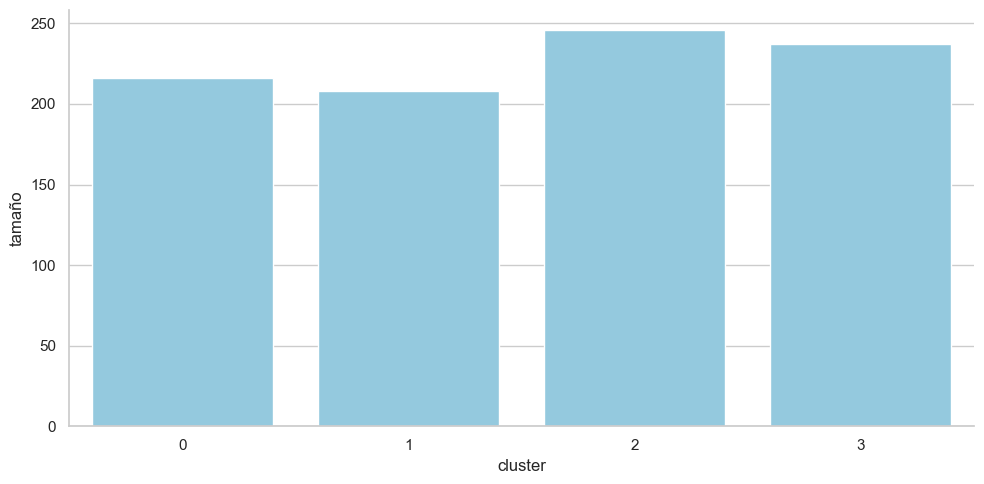

---------- Heatmap de centroides...
---------- Scatter matrix...


<Figure size 640x480 with 0 Axes>

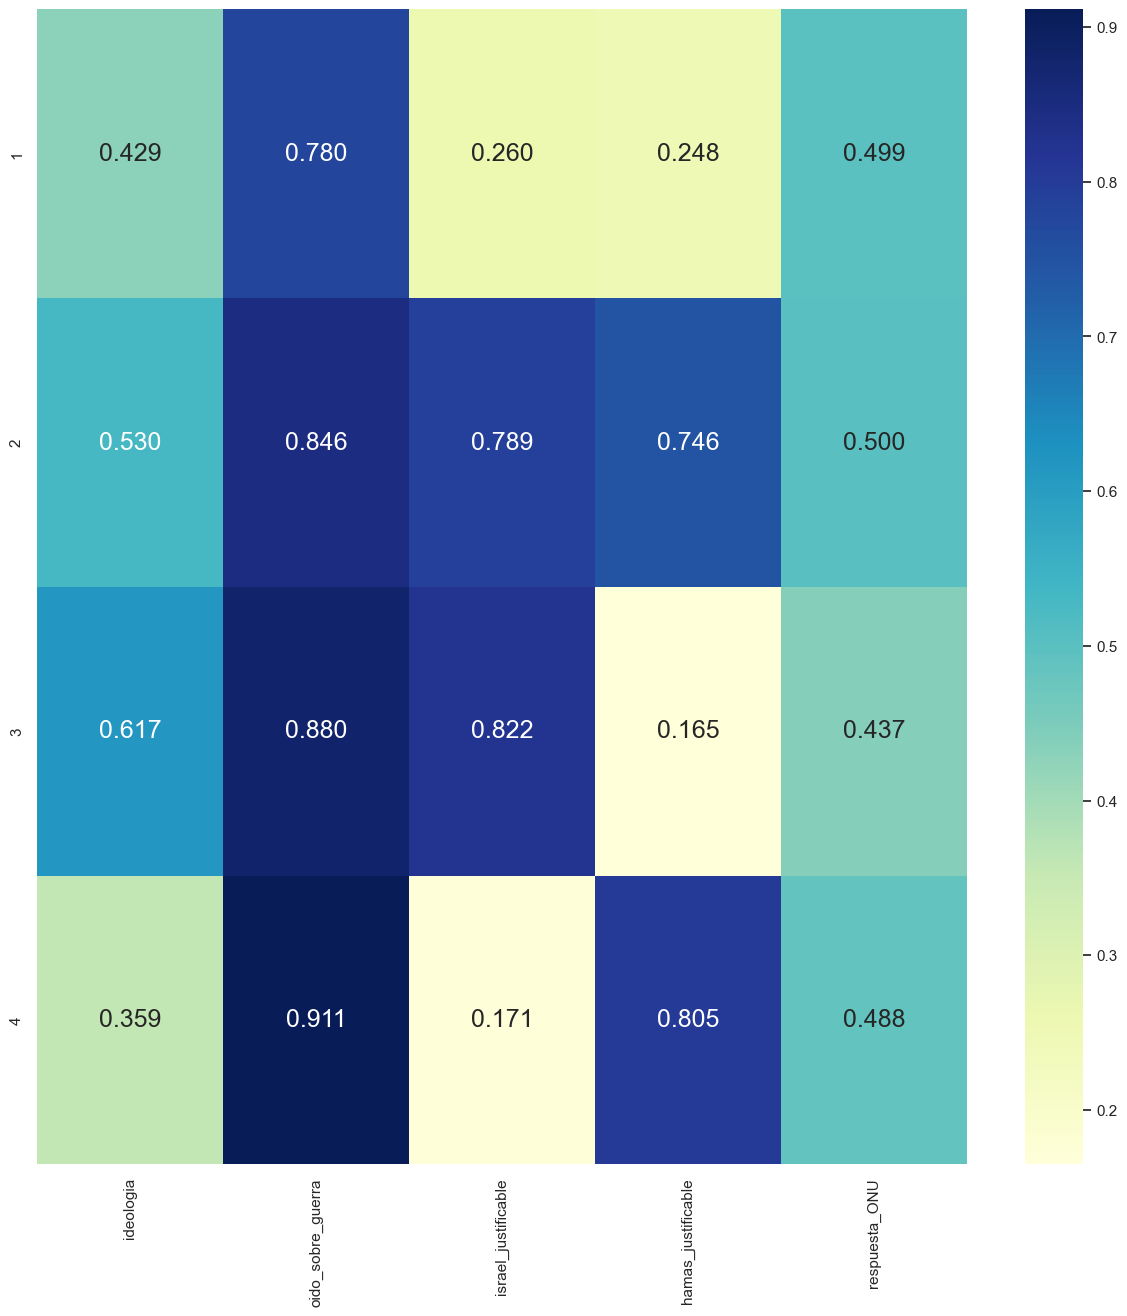

<Figure size 640x480 with 0 Axes>

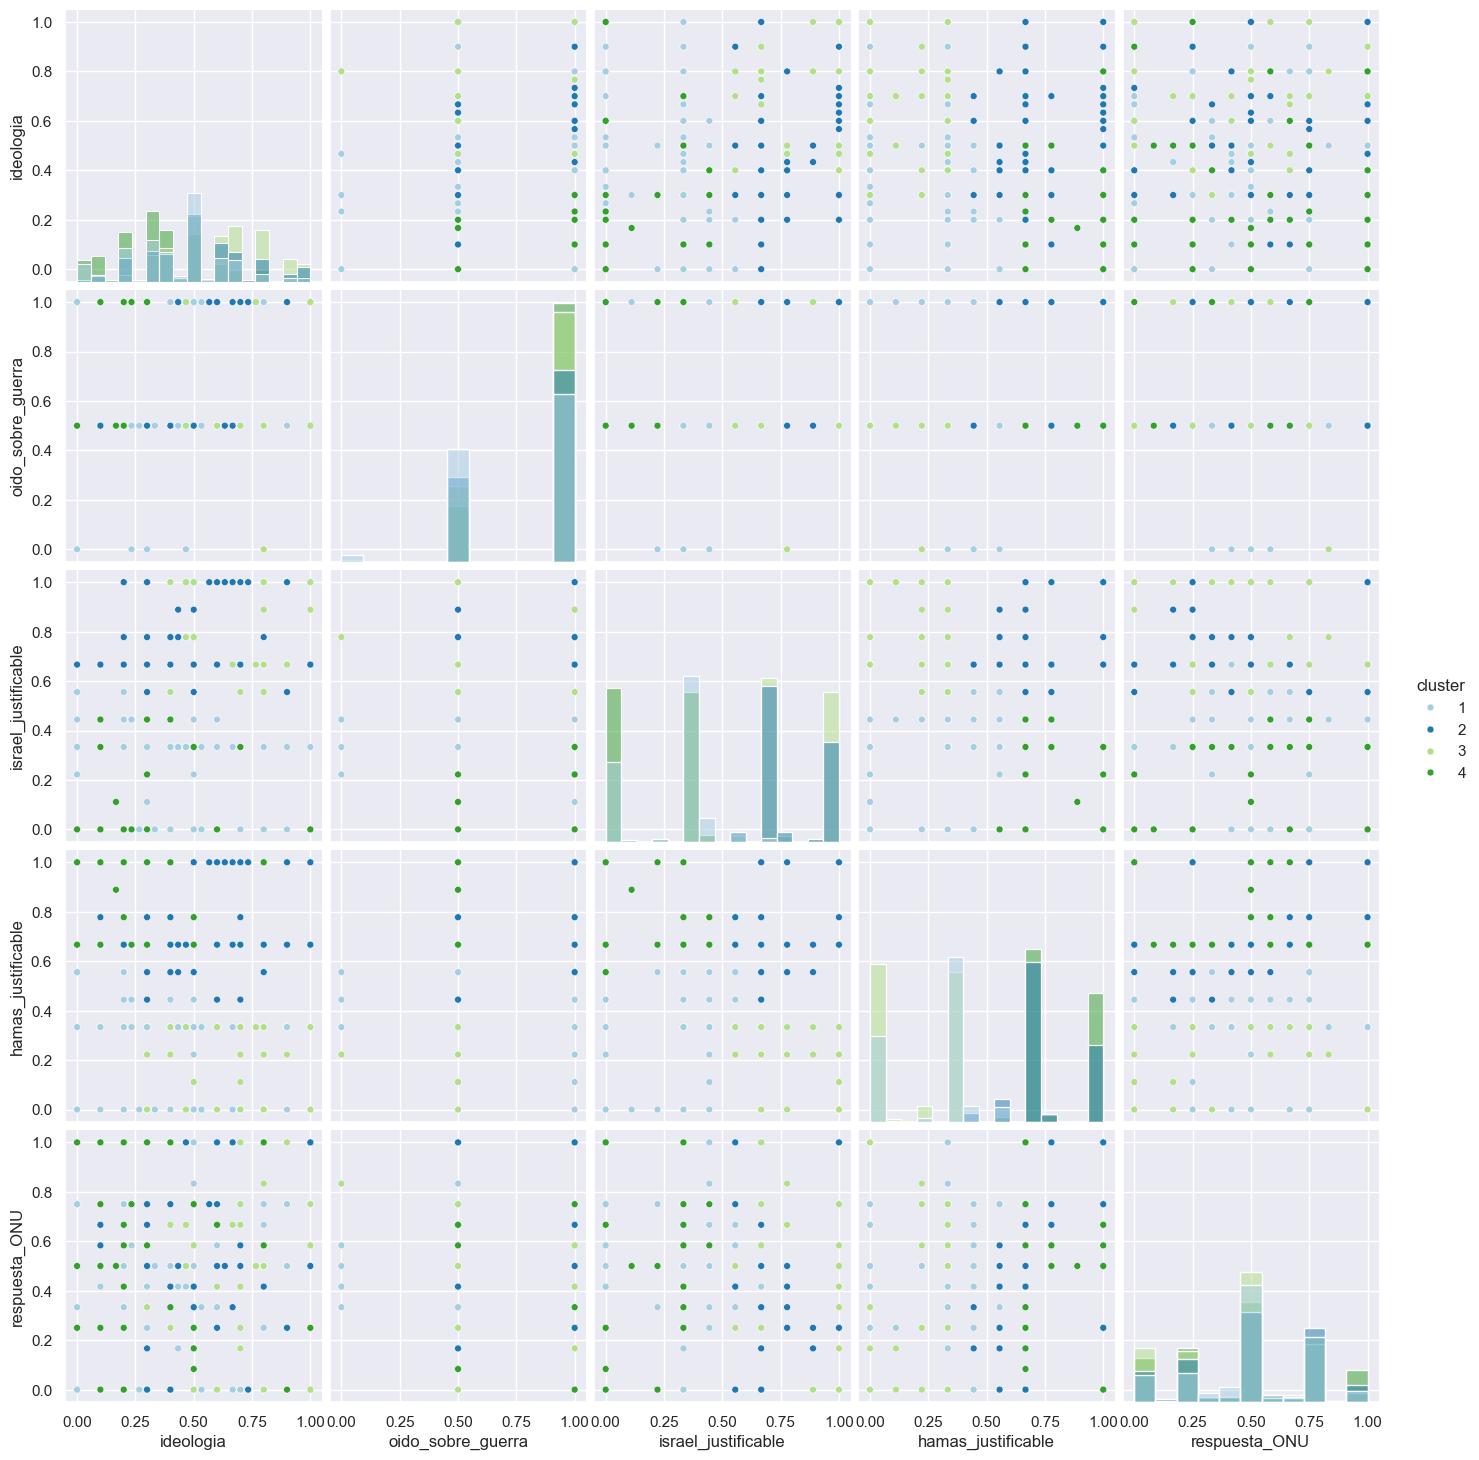

---------- MDS...


C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


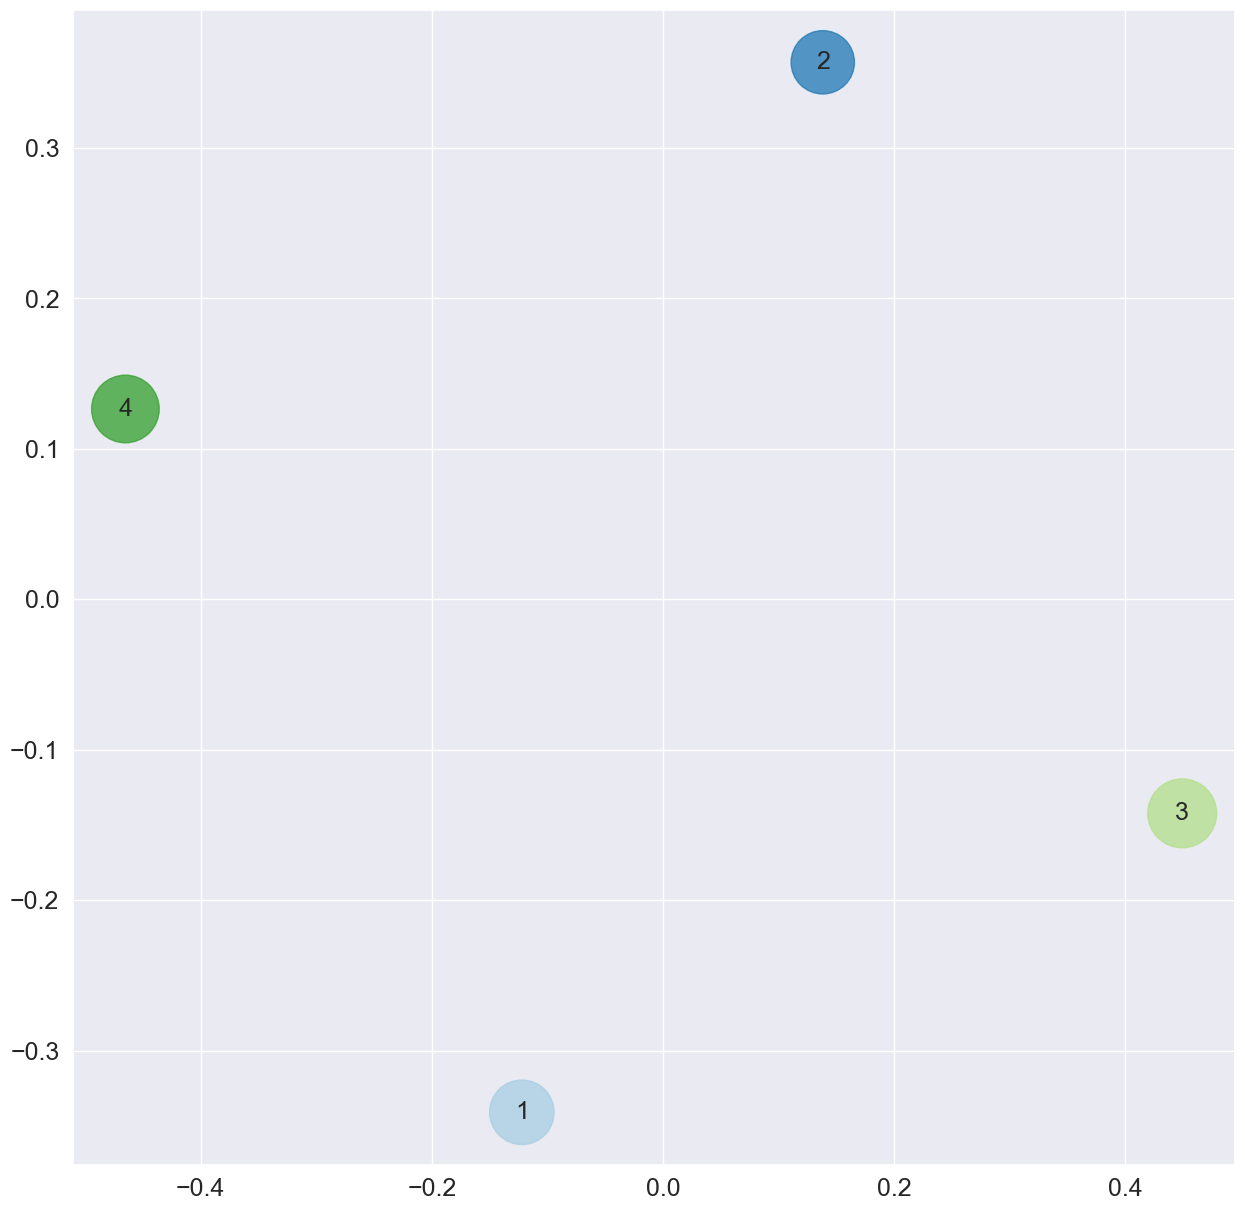

In [8]:
### VISUALIZACIÓN CASO 1B - kmeans
### Ejecutamos algoritmos
algoritmos = ['kmeans']
results_df = pd.DataFrame(columns=['Algoritmo', 'Tiempo (s)', 'Calinski-Harabasz', 'Silhouette', 'Número de clusters']) #Para la tabla

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        tiempo, kmeans_resultado, cluster_predict = kmeans(X_normal, subset)
        cluster_kmeans=cluster_predict
        
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    
    
#1. Gráfico de barras para representar el tamaño de los clusters
tabla_clusters = (
    [{'cluster': 0, 'tamaño': 216},
     {'cluster': 1, 'tamaño': 208},
     {'cluster': 2, 'tamaño': 246},
     {'cluster': 3, 'tamaño': 237}],
    pd.Series({0: 216, 1: 208, 2: 246, 3: 237}, name='count')
)

# Crear un DataFrame a partir de la lista de diccionarios
df = pd.DataFrame(tabla_clusters[0])

# Creamos el gráfico de barras
sns.set(style="whitegrid")
sns.catplot(y="tamaño", x="cluster", data=df, kind="bar", color="skyblue", aspect=2)
plt.show()

#2. Heatmap
heatmap(kmeans_resultado)

#3. Scatter matrix
# se añade la asignación de clusters como columna a X
X_kmeans = pd.concat([X, clusters], axis=1)
k = len(size)
colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
scatter(X_kmeans, colors)

#4. Boxplot
#boxplot(X_kmeans, cluster_kmeans)
#boxplot2(kmeans_resultado, X)

#5. MDS
centers, centers_desnormal = calcular_centros("kmeans", X, kmeans_resultado, cluster_kmeans)
MDS_plot(centers, size)

In [9]:
### CASO DE ESTUDIO 2
datos = pd.read_csv('03_Datos_noviembre_2023_num.csv')
peso = 'ponde'
tabla_medidas=[]

#Imputamos los valores perdidos
datos=imputar_valores_perdidos(datos)
#print(datos)

# Seleccionar casos, filtrando por rango de edad
subset = datos.loc[(datos['edad_r']<=0.2)] #Rangos de edad 1 y 2 (una vez normalizado es <0.4)

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"p5_1": "voto_PSOE", "p5_2": "voto_PP", "p5_3": "voto_VOX", "p5_4": "voto_SUMAR",
                              "p8_1": "cambio_climatico", "p8_3": "migracion", "p8_5": "inflacion", 
                              "p8_9": "pandemias"})
usadas = ['voto_PSOE', 'voto_PP','voto_VOX', 'voto_SUMAR', 'cambio_climatico', 'migracion', 'inflacion', 'pandemias']
print(subset[usadas])


n_var = len(usadas)
X = subset[usadas]

#eliminamos outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
X=eliminar_outliers(X)

# normalizamos
X_normal = X.apply(norm_to_zero_one)



### Ejecutamos algoritmos
algoritmos = ['kmeans', 'birch', 'meanshift', 'dbscan', 'single_linkage']
results_df = pd.DataFrame(columns=['Algoritmo', 'Tiempo (s)', 'Calinski-Harabasz', 'Silhouette', 'Número de clusters']) #Para la tabla

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        tiempo, kmeans_resultado, cluster_predict = kmeans(X_normal, subset)
        cluster_kmeans=cluster_predict
    elif algoritmos[i] == 'birch':
        tiempo, birch_resultado, cluster_predict = birch(15, 0.1, X_normal)
    elif algoritmos[i] == 'meanshift':
        bw = estimate_bandwidth(X_normal, quantile=0.05) #Utilizo el 5% de los datos para estimar el radiod
        #bw = estimate_bandwidth(X_normal)
        tiempo, meanshift_resultado, cluster_predict = meanshift(bw, X_normal)
    elif algoritmos[i] == 'dbscan':
        tiempo, dbscan_resultado, cluster_predict = dbscan(0.126, 15, X_normal)
    elif algoritmos[i] == 'single_linkage':
        tiempo, single_linkage_resultado, cluster_predict = single_linkage(X_normal, subset)
        
    try:
        ch=0
        sc=0
        print("\n\nMedidas\n\n")
        ch = CH_score(X_normal, cluster_predict)
        sc = SC_score(X_normal, cluster_predict)
    except:
        print("\n\nNo hay medidas :(\n\n")
        
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    #print(size)
    tamanio_cluster=len(tamano)
    if algoritmos[i]=='kmeans':
        tabla_clusters=tamano_clusters_tabla(clusters)
    
    # Generar tablita
    s = algoritmos[i]  + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(ch) + " & "
    s += "{:.5f}".format(sc) + " & "
    s += "{:.0f}".format(len(size)) + " \\\\"

    tabla_medidas.append(s)
    
    results_df = pd.concat([results_df, pd.DataFrame({
        'Algoritmo': [algoritmos[i]],
        'Tiempo (s)': [tiempo],
        'Calinski-Harabasz': [ch if 'ch' in locals() else None],
        'Silhouette': [sc if 'sc' in locals() else None],
        'Número de clusters': [tamanio_cluster]
    })], ignore_index=True)

#Imprimir tablita
#print(results_df)

tabla_medidas_formato(tabla_medidas)

      voto_PSOE   voto_PP  voto_VOX  voto_SUMAR  cambio_climatico  migracion  \
6           0.0  0.800000       0.6         0.0          0.666667   1.000000   
20          0.0  0.000000       0.0         0.1          1.000000   1.000000   
30          0.0  0.000000       0.0         0.0          0.666667   0.666667   
44          0.1  1.000000       0.1         0.0          0.666667   0.666667   
46          0.0  0.000000       0.0         0.0          0.666667   1.000000   
...         ...       ...       ...         ...               ...        ...   
1980        0.8  0.600000       0.0         0.7          0.666667   0.333333   
1983        0.0  0.000000       0.0         0.7          0.666667   0.333333   
1986        0.0  0.900000       1.0         0.0          0.666667   0.666667   
1987        0.5  0.433333       0.1         0.0          0.555556   0.444444   
1988        0.5  0.900000       0.4         0.6          1.000000   0.333333   

      inflacion  pandemias  
6      0.6

C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\monic\AppData\Local\Temp\ipykernel_7648\441443151.py:79: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


: 0.75 segundos, 

Medidas


Calinski-Harabasz Index: 26.202, Silhouette Coefficient: 0.09435
Tamaño de cada cluster:
0:   137 (36.15%)
1:    68 (17.94%)
2:   129 (34.04%)
3:     8 ( 2.11%)
4:    11 ( 2.90%)
5:     9 ( 2.37%)
6:     3 ( 0.79%)
7:     2 ( 0.53%)
8:     5 ( 1.32%)
9:     4 ( 1.06%)
10:     3 ( 0.79%)
----- Ejecutando DBSCAN: minPts=15, eps=0.126: 0.00 segundos, 

Medidas




No hay medidas :(


Tamaño de cada cluster:
0:   379 (100.00%)
----- Ejecutando Single Linkage Hierarchical Clustering: 0.00 segundos, 

Medidas


Calinski-Harabasz Index: 1.706, Silhouette Coefficient: 0.02411
Tamaño de cada cluster:
0:   376 (99.21%)
1:     1 ( 0.26%)
2:     1 ( 0.26%)
3:     1 ( 0.26%)
\begin{table}[H]
\centering
\caption{Resultados medidas}
\label{tab:medidas_casoX}
\begin{tabular}{llrrrrr}
\toprule
 Algoritmo & Tiempo (s)  & Calinski-Harabasz & Silhouette & Número de clusters \\
\midrule
kmeans & 0.043 & 83.399 & 0.17788 & 4 \\
birch & 0.043 & 66.952 & 0.15666 & 4 \\
meanshift &

----- Ejecutando k-Means: 0.04 segundos, Tamaño de cada cluster:
0:    64 (16.89%)
1:    81 (21.37%)
2:    89 (23.48%)
3:    85 (22.43%)
4:    60 (15.83%)


C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


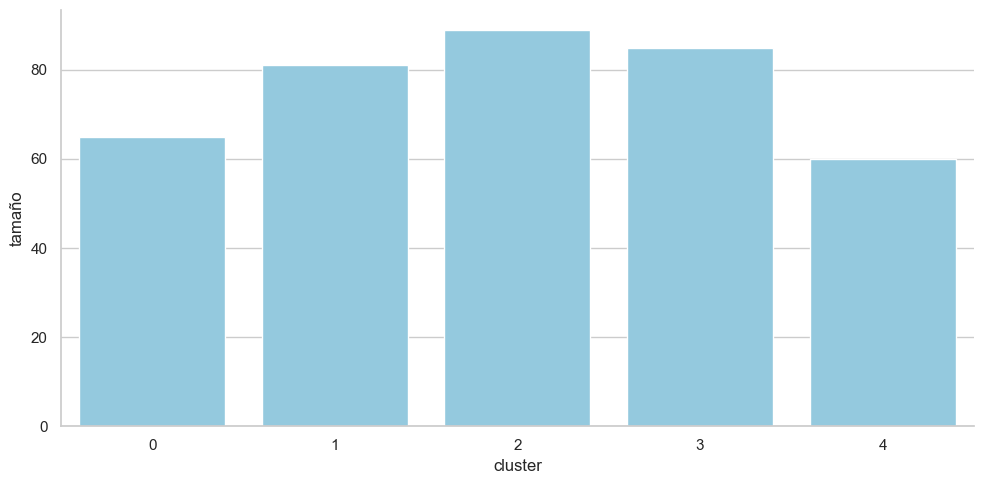

---------- Heatmap de centroides...
---------- Scatter matrix...


<Figure size 640x480 with 0 Axes>

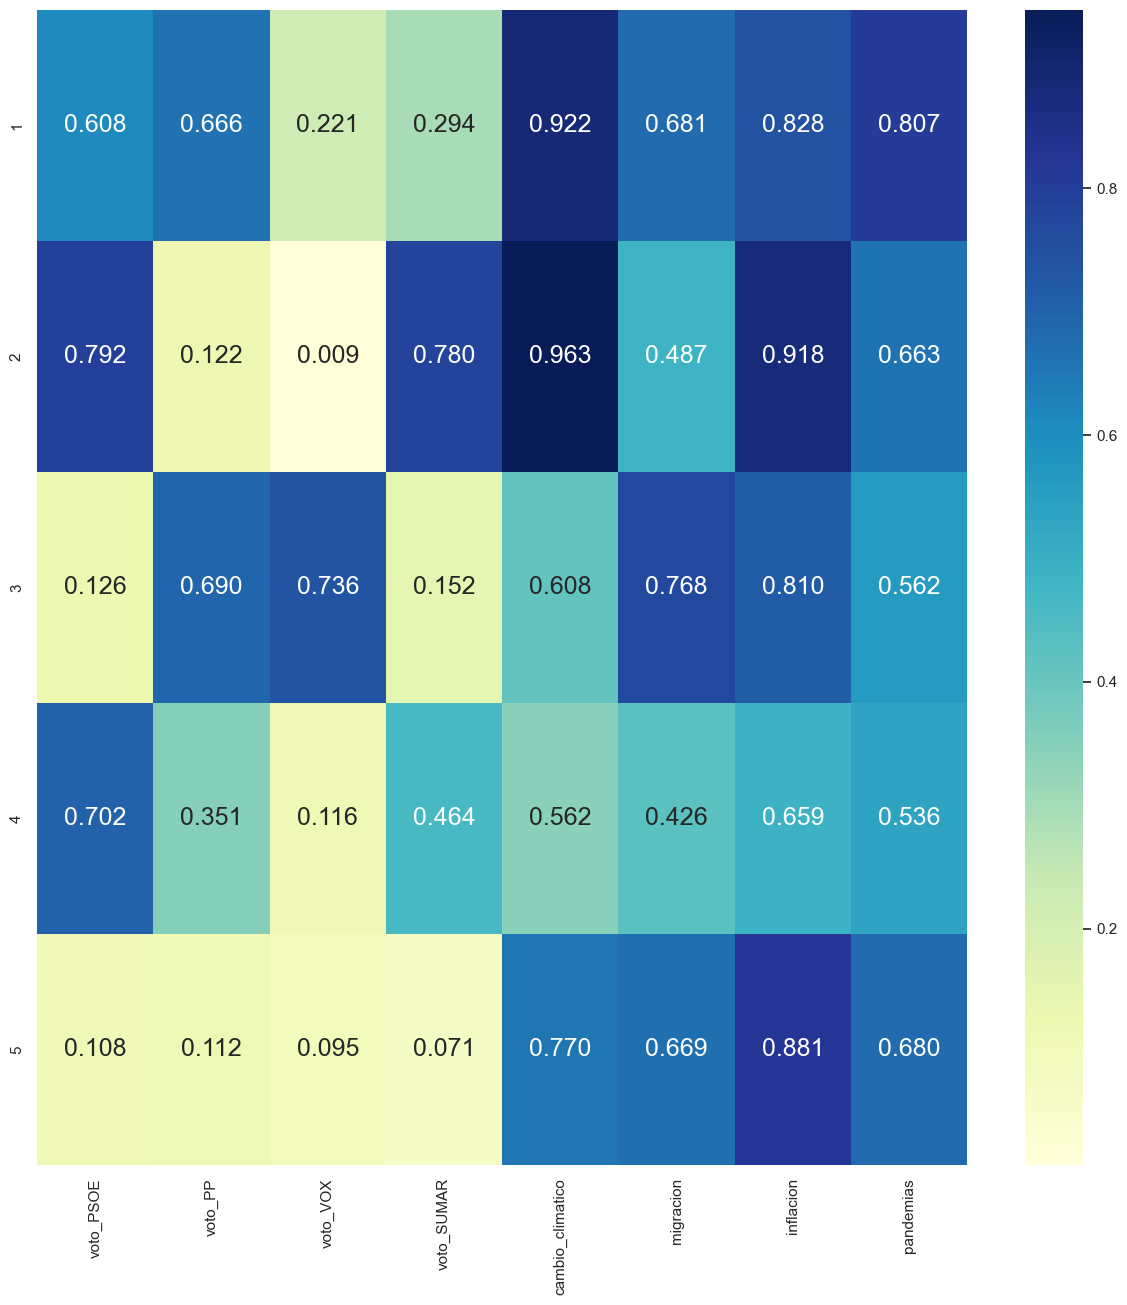

<Figure size 640x480 with 0 Axes>

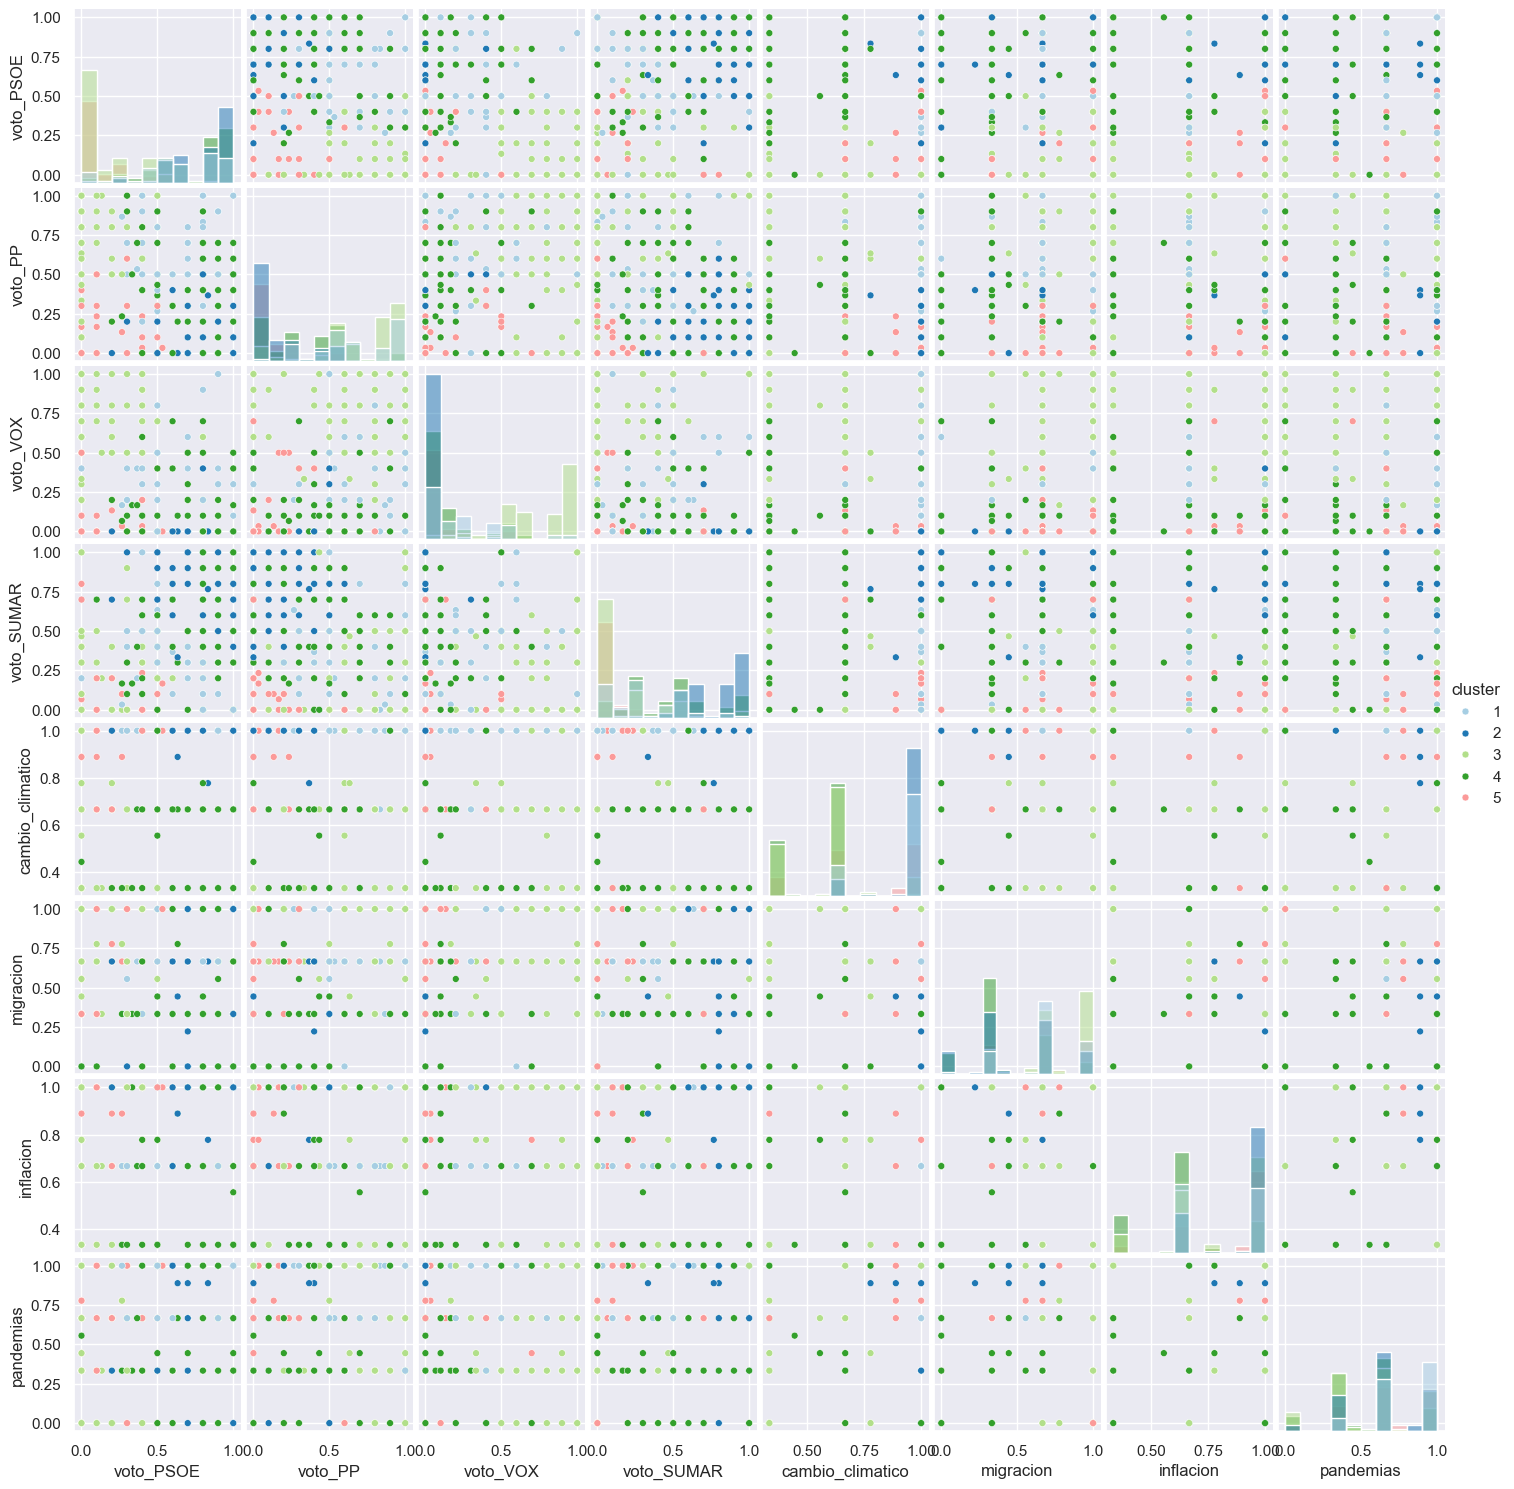

---------- MDS...


C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


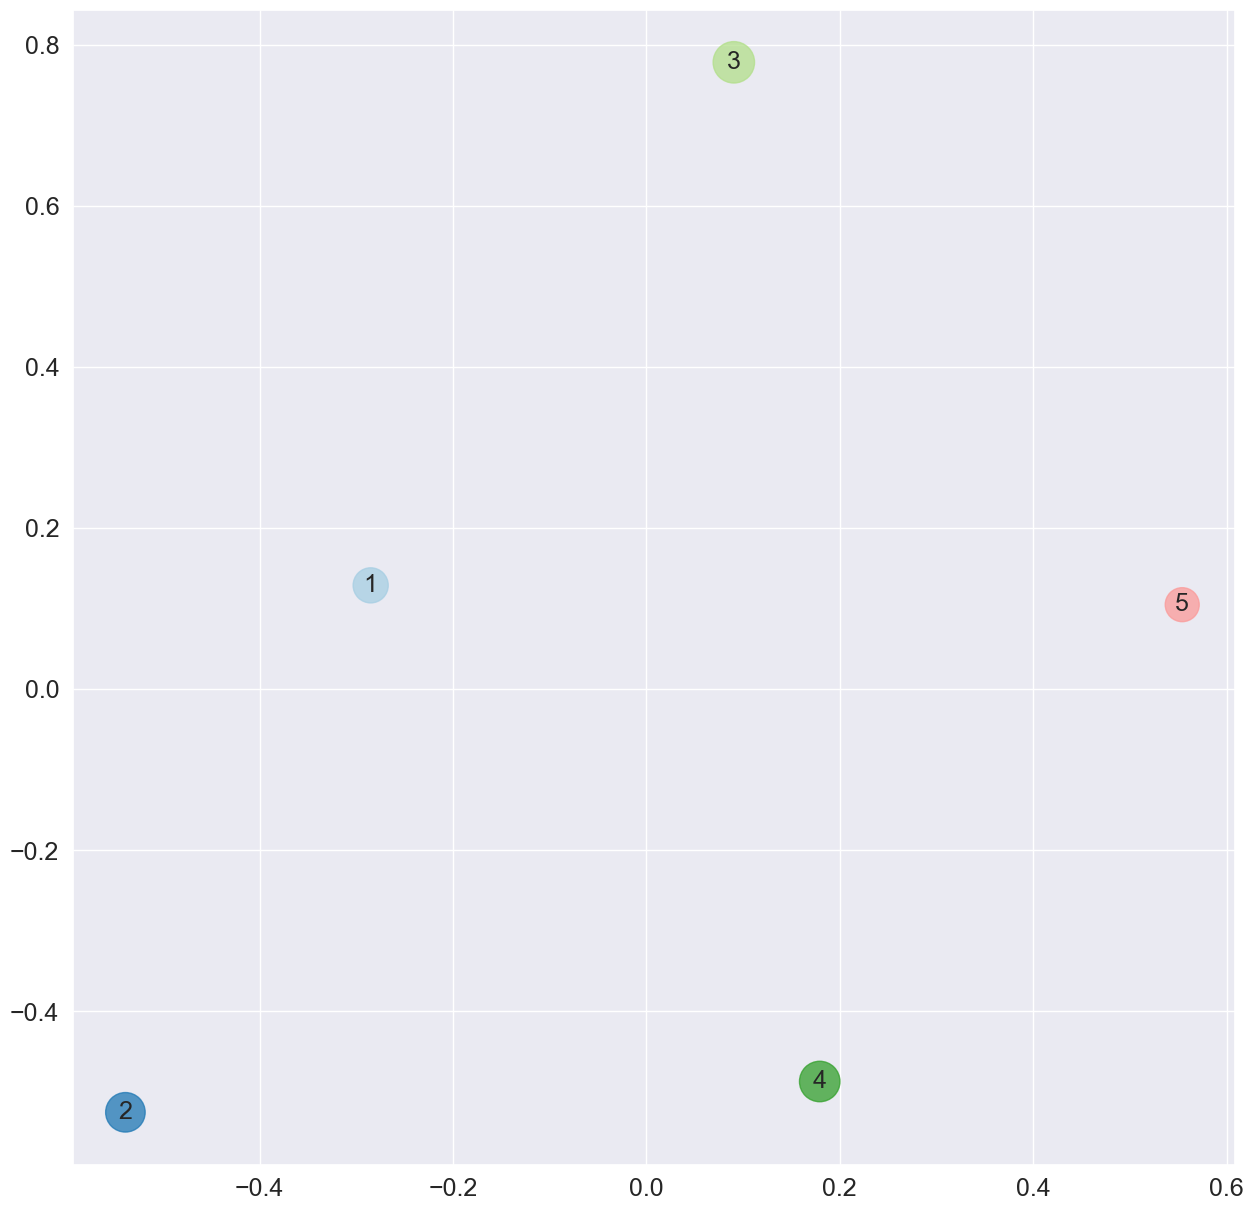

In [10]:
### VISUALIZACIÓN CASO 2 - kmeans
### Ejecutamos algoritmos
algoritmos = ['kmeans']
results_df = pd.DataFrame(columns=['Algoritmo', 'Tiempo (s)', 'Calinski-Harabasz', 'Silhouette', 'Número de clusters']) #Para la tabla

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        tiempo, kmeans_resultado, cluster_predict = kmeans(X_normal, subset, n_clusters_arg=5)
        cluster_kmeans=cluster_predict
        
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    
    
#1. Gráfico de barras para representar el tamaño de los clusters
tabla_clusters = (
    [{'cluster': 0, 'tamaño': 65},
     {'cluster': 1, 'tamaño': 81},
     {'cluster': 2, 'tamaño': 89},
     {'cluster': 3, 'tamaño': 85},
     {'cluster': 4, 'tamaño': 60},],
    pd.Series({0: 65, 1: 81, 2: 89, 3: 85, 4:60}, name='count')
)

# Crear un DataFrame a partir de la lista de diccionarios
df = pd.DataFrame(tabla_clusters[0])

# Creamos el gráfico de barras
sns.set(style="whitegrid")
sns.catplot(y="tamaño", x="cluster", data=df, kind="bar", color="skyblue", aspect=2)
plt.show()

#2. Heatmap
heatmap(kmeans_resultado)

#3. Scatter matrix
# se añade la asignación de clusters como columna a X
X_kmeans = pd.concat([X, clusters], axis=1)
k = len(size)
colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
scatter(X_kmeans, colors)

#4. Boxplot
#boxplot(X_kmeans, cluster_kmeans)
#boxplot2(kmeans_resultado, X)

#5. MDS
centers, centers_desnormal = calcular_centros("kmeans", X, kmeans_resultado, cluster_kmeans)
MDS_plot(centers, size)

In [11]:
### CASO DE ESTUDIO 2: Estudio de parámetros en Meanshift
datos = pd.read_csv('03_Datos_noviembre_2023_num.csv')
peso = 'ponde'
tabla_parametros=[]

#Imputamos los valores perdidos
datos=imputar_valores_perdidos(datos)

# Seleccionar casos, filtrando por rango de edad
subset = datos.loc[(datos['edad_r']<=0.2)] #Rangos de edad 1 y 2 (una vez normalizado es <0.4)

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"p5_1": "voto_PSOE", "p5_2": "voto_PP", "p5_3": "voto_VOX", "p5_4": "voto_SUMAR",
                              "p8_1": "cambio_climatico", "p8_3": "migracion", "p8_5": "inflacion", 
                              "p8_9": "pandemias"})
usadas = ['voto_PSOE', 'voto_PP','voto_VOX', 'voto_SUMAR', 'cambio_climatico', 'migracion', 'inflacion', 'pandemias']
#print(subset[usadas])


n_var = len(usadas)
X = subset[usadas]

#eliminamos outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
X=eliminar_outliers(X)

# normalizamos
X_normal = X.apply(norm_to_zero_one)


parametros_branching_factor=[15, 20, 25, 30, 35]
parametros_threshold=[0.1, 0.12, 0.15, 0.2, 0.25]
parametros_bandwith=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.72, 0.75, 0.76, 0.77, 0.78, 0.8, 0.9, 1]

for i in range(0, len(parametros_bandwith)):
    tiempo, meanshift_resultado, cluster_predict = meanshift(parametros_bandwith[i], X_normal)
        
    try:
        print("\n\nMedidas\n\n") 
        ch = CH_score(X_normal, cluster_predict)
        sc = SC_score(X_normal, cluster_predict)
    except:
        print("\n\nNo hay medidas :(\n\n") #Cuando sólo hay 1 cluster, no se pueden sacar medidas 

    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    #print(size)
    tamanio_cluster=len(tamano)

    s = "meanshift"  + " & "
    s += "{:.3f}".format(parametros_bandwith[i]) + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(sc) + " & "
    s += "{:.5f}".format(ch) + " & "
    s += "{:.0f}".format(len(size)) + " \\\\"

    tabla_parametros.append(s)

tabla_parametros_formato(tabla_parametros, "meanshift")

----- Ejecutando meanshift con radio=0.1: 0.18 segundos, 

Medidas


Calinski-Harabasz Index: 549.505, Silhouette Coefficient: 0.05532
Tamaño de cada cluster:
0:     3 ( 0.79%)
1:     2 ( 0.53%)
2:     2 ( 0.53%)
3:     2 ( 0.53%)
4:     2 ( 0.53%)
5:     2 ( 0.53%)
6:     2 ( 0.53%)
7:     2 ( 0.53%)
8:     2 ( 0.53%)
9:     2 ( 0.53%)
10:     2 ( 0.53%)
11:     2 ( 0.53%)
12:     1 ( 0.26%)
13:     1 ( 0.26%)
14:     1 ( 0.26%)
15:     1 ( 0.26%)
16:     1 ( 0.26%)
17:     1 ( 0.26%)
18:     1 ( 0.26%)
19:     1 ( 0.26%)
20:     1 ( 0.26%)
21:     1 ( 0.26%)
22:     1 ( 0.26%)
23:     1 ( 0.26%)
24:     1 ( 0.26%)
25:     1 ( 0.26%)
26:     1 ( 0.26%)
27:     1 ( 0.26%)
28:     1 ( 0.26%)
29:     1 ( 0.26%)
30:     1 ( 0.26%)
31:     1 ( 0.26%)
32:     1 ( 0.26%)
33:     1 ( 0.26%)
34:     1 ( 0.26%)
35:     1 ( 0.26%)
36:     1 ( 0.26%)
37:     1 ( 0.26%)
38:     1 ( 0.26%)
39:     1 ( 0.26%)
40:     1 ( 0.26%)
41:     1 ( 0.26%)
42:     1 ( 0.26%)
43:     1 ( 0.26%)
44:     1 ( 0.2

----- Ejecutando meanshift con radio=0.3: 0.21 segundos, 

Medidas


Calinski-Harabasz Index: 35.667, Silhouette Coefficient: 0.13690
Tamaño de cada cluster:
0:     9 ( 2.37%)
1:     7 ( 1.85%)
2:     5 ( 1.32%)
3:     4 ( 1.06%)
4:     6 ( 1.58%)
5:     4 ( 1.06%)
6:     3 ( 0.79%)
7:     4 ( 1.06%)
8:     4 ( 1.06%)
9:     3 ( 0.79%)
10:     3 ( 0.79%)
11:     3 ( 0.79%)
12:     3 ( 0.79%)
13:     3 ( 0.79%)
14:     3 ( 0.79%)
15:     3 ( 0.79%)
16:     2 ( 0.53%)
17:     2 ( 0.53%)
18:     2 ( 0.53%)
19:     2 ( 0.53%)
20:     2 ( 0.53%)
21:     2 ( 0.53%)
22:     2 ( 0.53%)
23:     2 ( 0.53%)
24:     2 ( 0.53%)
25:     2 ( 0.53%)
26:     2 ( 0.53%)
27:     2 ( 0.53%)
28:     2 ( 0.53%)
29:     2 ( 0.53%)
30:     2 ( 0.53%)
31:     2 ( 0.53%)
32:     2 ( 0.53%)
33:     2 ( 0.53%)
34:     2 ( 0.53%)
35:     2 ( 0.53%)
36:     2 ( 0.53%)
37:     2 ( 0.53%)
38:     2 ( 0.53%)
39:     1 ( 0.26%)
40:     1 ( 0.26%)
41:     1 ( 0.26%)
42:     1 ( 0.26%)
43:     1 ( 0.26%)
44:     1 ( 0.26

----- Ejecutando meanshift con radio=0.5: 0.52 segundos, 

Medidas


Calinski-Harabasz Index: 13.843, Silhouette Coefficient: 0.09930
Tamaño de cada cluster:
0:    48 (12.66%)
1:    19 ( 5.01%)
2:    15 ( 3.96%)
3:    17 ( 4.49%)
4:    12 ( 3.17%)
5:    12 ( 3.17%)
6:    10 ( 2.64%)
7:    10 ( 2.64%)
8:     7 ( 1.85%)
9:     6 ( 1.58%)
10:     8 ( 2.11%)
11:    11 ( 2.90%)
12:     6 ( 1.58%)
13:     7 ( 1.85%)
14:     6 ( 1.58%)
15:     4 ( 1.06%)
16:     4 ( 1.06%)
17:     4 ( 1.06%)
18:     4 ( 1.06%)
19:     4 ( 1.06%)
20:     3 ( 0.79%)
21:     5 ( 1.32%)
22:     4 ( 1.06%)
23:     3 ( 0.79%)
24:     3 ( 0.79%)
25:     2 ( 0.53%)
26:     5 ( 1.32%)
27:     2 ( 0.53%)
28:     9 ( 2.37%)
29:     3 ( 0.79%)
30:     2 ( 0.53%)
31:     4 ( 1.06%)
32:     3 ( 0.79%)
33:     2 ( 0.53%)
34:     2 ( 0.53%)
35:     2 ( 0.53%)
36:     2 ( 0.53%)
37:     3 ( 0.79%)
38:     2 ( 0.53%)
39:     2 ( 0.53%)
40:     2 ( 0.53%)
41:     2 ( 0.53%)
42:     1 ( 0.26%)
43:     1 ( 0.26%)
44:     1 ( 0.26

In [12]:
### CASO DE ESTUDIO 2: Estudio de parámetros en K-Means
datos = pd.read_csv('03_Datos_noviembre_2023_num.csv')
peso = 'ponde'
tabla_parametros=[]

#Imputamos los valores perdidos
datos=imputar_valores_perdidos(datos)

# Seleccionar casos, filtrando por rango de edad
subset = datos.loc[(datos['edad_r']<=0.2)] #Rangos de edad 1 y 2 (una vez normalizado es <0.4)

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"p5_1": "voto_PSOE", "p5_2": "voto_PP", "p5_3": "voto_VOX", "p5_4": "voto_SUMAR",
                              "p8_1": "cambio_climatico", "p8_3": "migracion", "p8_5": "inflacion", 
                              "p8_9": "pandemias"})
usadas = ['voto_PSOE', 'voto_PP','voto_VOX', 'voto_SUMAR', 'cambio_climatico', 'migracion', 'inflacion', 'pandemias']
#print(subset[usadas])


n_var = len(usadas)
X = subset[usadas]

#eliminamos outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
X=eliminar_outliers(X)

# normalizamos
X_normal = X.apply(norm_to_zero_one)



for i in range(1, 21,2):
    tiempo, kmeans_resultado, cluster_predict = kmeans(X_normal, subset,n_clusters_arg=i )
        
    try:
        print("\n\nMedidas\n\n") 
        ch = CH_score(X_normal, cluster_predict)
        sc = SC_score(X_normal, cluster_predict)
    except:
        print("\n\nNo hay medidas :(\n\n") #Cuando sólo hay 1 cluster, no se pueden sacar medidas 

    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    #print(size)
    tamanio_cluster=len(tamano)

    s = "kmeans"  + " & "
    s += "{:.3f}".format(i) + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(sc) + " & "
    s += "{:.5f}".format(ch) + " & "
    s += "{:.0f}".format(i) + " \\\\"

    tabla_parametros.append(s)
    
    
tabla_parametros_formato(tabla_parametros, "meanshift")

----- Ejecutando k-Means: 0.03 segundos, 

Medidas




No hay medidas :(


Tamaño de cada cluster:
0:   379 (100.00%)
----- Ejecutando k-Means: 0.04 segundos, 

Medidas


Calinski-Harabasz Index: 93.784, Silhouette Coefficient: 0.18698
Tamaño de cada cluster:
0:   173 (45.65%)
1:   105 (27.70%)
2:   101 (26.65%)
----- Ejecutando k-Means: 0.04 segundos, 

Medidas


Calinski-Harabasz Index: 76.024, Silhouette Coefficient: 0.17512
Tamaño de cada cluster:
0:    64 (16.89%)
1:    81 (21.37%)
2:    89 (23.48%)
3:    85 (22.43%)
4:    60 (15.83%)
----- Ejecutando k-Means: 0.04 segundos, 

Medidas


Calinski-Harabasz Index: 65.143, Silhouette Coefficient: 0.17185
Tamaño de cada cluster:
0:    48 (12.66%)
1:    55 (14.51%)
2:    73 (19.26%)
3:    37 ( 9.76%)
4:    37 ( 9.76%)
5:    52 (13.72%)
6:    77 (20.32%)
----- Ejecutando k-Means

C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_

: 0.04 segundos, 

Medidas


Calinski-Harabasz Index: 55.486, Silhouette Coefficient: 0.14179
Tamaño de cada cluster:
0:    36 ( 9.50%)
1:    56 (14.78%)
2:    42 (11.08%)
3:    47 (12.40%)
4:    49 (12.93%)
5:    39 (10.29%)
6:    39 (10.29%)
7:    30 ( 7.92%)
8:    41 (10.82%)
----- Ejecutando k-Means: 0.04 segundos, 

Medidas


Calinski-Harabasz Index: 49.791, Silhouette Coefficient: 0.15921
Tamaño de cada cluster:
0:    31 ( 8.18%)
1:    39 (10.29%)
2:    29 ( 7.65%)
3:    26 ( 6.86%)
4:    22 ( 5.80%)
5:    32 ( 8.44%)
6:    36 ( 9.50%)
7:    21 ( 5.54%)
8:    54 (14.25%)
9:    54 (14.25%)
10:    35 ( 9.23%)
----- Ejecutando k-Means: 0.04 segundos, 

Medidas


Calinski-Harabasz Index: 46.310, Silhouette Coefficient: 0.15235
Tamaño de cada cluster:
0:    29 ( 7.65%)
1:    32 ( 8.44%)
2:    37 ( 9.76%)
3:    50 (13.19%)
4:    26 ( 6.86%)
5:    20 ( 5.28%)
6:    25 ( 6.60%)
7:    12 ( 3.17%)
8:    29 ( 7.65%)
9:    24 ( 6.33%)
10:    30 ( 7.92%)
11:    41 (10.82%)
12:    24 ( 6.33%)


C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_

: 0.05 segundos, 

Medidas


Calinski-Harabasz Index: 40.428, Silhouette Coefficient: 0.15807
Tamaño de cada cluster:
0:    11 ( 2.90%)
1:    33 ( 8.71%)
2:    18 ( 4.75%)
3:    23 ( 6.07%)
4:    31 ( 8.18%)
5:    26 ( 6.86%)
6:    22 ( 5.80%)
7:    21 ( 5.54%)
8:    17 ( 4.49%)
9:    12 ( 3.17%)
10:    14 ( 3.69%)
11:    34 ( 8.97%)
12:    27 ( 7.12%)
13:    27 ( 7.12%)
14:    23 ( 6.07%)
15:    17 ( 4.49%)
16:    23 ( 6.07%)
----- Ejecutando k-Means: 0.05 segundos, 

Medidas


Calinski-Harabasz Index: 38.635, Silhouette Coefficient: 0.15889
Tamaño de cada cluster:
0:    21 ( 5.54%)
1:    27 ( 7.12%)
2:    33 ( 8.71%)
3:    24 ( 6.33%)
4:    10 ( 2.64%)
5:    26 ( 6.86%)
6:    11 ( 2.90%)
7:    31 ( 8.18%)
8:    20 ( 5.28%)
9:    28 ( 7.39%)
10:    23 ( 6.07%)
11:    11 ( 2.90%)
12:    18 ( 4.75%)
13:    19 ( 5.01%)
14:    14 ( 3.69%)
15:    10 ( 2.64%)
16:    15 ( 3.96%)
17:    28 ( 7.39%)
18:    10 ( 2.64%)
\begin{table}[H]
\centering
\caption{Resultados cambio de parámetros}
\label

C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [13]:
### CASO DE ESTUDIO 3
datos = pd.read_csv('03_Datos_noviembre_2023_num.csv')
peso = 'ponde'
tabla_medidas=[]

#Imputamos los valores perdidos
datos=imputar_valores_perdidos(datos)
#print(datos)

# Seleccionar casos, filtrando por sexo
subset = datos.loc[(datos['sexo']==1)] #Sexo=mujer (1=2 después de normalizar :)

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"cs": "clase social", "p1": "situacion economica", "p7": "ideologia",
                              "p9_5": "crisis_inflacion"})
usadas = ['edad', 'clase social','situacion economica', 'ideologia', 'crisis_inflacion']
#print(subset[usadas])


n_var = len(usadas)
X = subset[usadas]

#eliminamos outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
#X=eliminar_outliers(X)

# normalizamos
X_normal = X.apply(norm_to_zero_one)

print(X_normal)

### Ejecutamos algoritmos
algoritmos = ['kmeans', 'birch', 'meanshift', 'dbscan', 'single_linkage']
results_df = pd.DataFrame(columns=['Algoritmo', 'Tiempo (s)', 'Calinski-Harabasz', 'Silhouette', 'Número de clusters']) #Para la tabla

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        tiempo, kmeans_resultado, cluster_predict = kmeans(X_normal, subset)
        cluster_kmeans=cluster_predict
    elif algoritmos[i] == 'birch':
        tiempo, birch_resultado, cluster_predict = birch(15, 0.1, X_normal)
    elif algoritmos[i] == 'meanshift':
        bw = estimate_bandwidth(X_normal, quantile=0.05) #Utilizo el 5% de los datos para estimar el radiod
        #bw = estimate_bandwidth(X_normal)
        tiempo, meanshift_resultado, cluster_predict = meanshift(bw, X_normal)
    elif algoritmos[i] == 'dbscan':
        tiempo, dbscan_resultado, cluster_predict = dbscan(0.126, 15, X_normal)
    elif algoritmos[i] == 'single_linkage':
        tiempo, single_linkage_resultado, cluster_predict = single_linkage(X_normal, subset)
        
    try:
        ch=0
        sc=0
        print("\n\nMedidas\n\n")
        ch = CH_score(X_normal, cluster_predict)
        sc = SC_score(X_normal, cluster_predict)
    except:
        print("\n\nNo hay medidas :(\n\n")
        
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    #print(size)
    tamanio_cluster=len(tamano)
    if algoritmos[i]=='kmeans':
        tabla_clusters=tamano_clusters_tabla(clusters)
    
    # Generar tablita
    s = algoritmos[i]  + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(ch) + " & "
    s += "{:.5f}".format(sc) + " & "
    s += "{:.0f}".format(len(size)) + " \\\\"

    tabla_medidas.append(s)
    
    results_df = pd.concat([results_df, pd.DataFrame({
        'Algoritmo': [algoritmos[i]],
        'Tiempo (s)': [tiempo],
        'Calinski-Harabasz': [ch if 'ch' in locals() else None],
        'Silhouette': [sc if 'sc' in locals() else None],
        'Número de clusters': [tamanio_cluster]
    })], ignore_index=True)

#Imprimir tablita
#print(results_df)

tabla_medidas_formato(tabla_medidas)

          edad  clase social  situacion economica  ideologia  crisis_inflacion
1     0.371429      0.833333                 0.50   0.600000               0.5
2     0.385714      0.666667                 0.50   0.666667               0.0
3     0.757143      0.833333                 0.00   0.500000               0.5
8     0.785714      0.500000                 0.25   0.300000               1.0
11    0.714286      0.333333                 0.75   0.500000               0.5
...        ...           ...                  ...        ...               ...
1992  0.557143      0.000000                 0.25   0.400000               0.5
1993  0.328571      0.666667                 0.00   0.500000               0.5
1995  0.414286      0.500000                 0.75   0.600000               1.0
1997  0.671429      0.500000                 0.00   0.800000               0.0
1998  0.742857      0.500000                 0.50   0.500000               1.0

[1065 rows x 5 columns]
----- Ejecutando k-Means: 0

C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\monic\AppData\Local\Temp\ipykernel_7648\3176109933.py:78: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({


Silhouette Coefficient: 0.14825
Tamaño de cada cluster:
0:   320 (30.05%)
1:   159 (14.93%)
2:   252 (23.66%)
3:   334 (31.36%)
----- Ejecutando meanshift con radio=0.4119830186082422: 5.25 segundos, 

Medidas


Calinski-Harabasz Index: 174.685, Silhouette Coefficient: 0.20247
Tamaño de cada cluster:
0:   613 (57.56%)
1:   254 (23.85%)
2:   163 (15.31%)
3:    35 ( 3.29%)
----- Ejecutando DBSCAN: minPts=15, eps=0.126: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 3.431, Silhouette Coefficient: -0.27459
Tamaño de cada cluster:
0:  1031 (96.81%)
1:    18 ( 1.69%)
2:    16 ( 1.50%)
----- Ejecutando Single Linkage Hierarchical Clustering: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 159.761, Silhouette Coefficient: 0.20061
Tamaño de cada cluster:
0:   254 (23.85%)
1:   184 (17.28%)
2:   626 (58.78%)
3:     1 ( 0.09%)
\begin{table}[H]
\centering
\caption{Resultados medidas}
\label{tab:medidas_casoX}
\begin{tabular}{llrrrrr}
\toprule
 Algoritmo & Tiempo (s)  & Calinski-Harabasz &

----- Ejecutando k-Means: 0.06 segundos, Tamaño de cada cluster:
0:   166 (15.59%)
1:   320 (30.05%)
2:   222 (20.85%)
3:   357 (33.52%)


C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


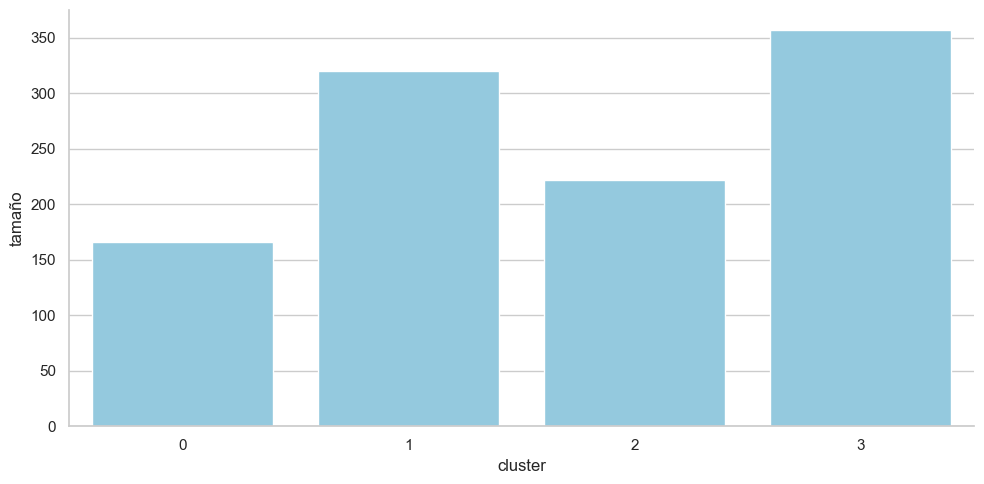

---------- Heatmap de centroides...
---------- Scatter matrix...


<Figure size 640x480 with 0 Axes>

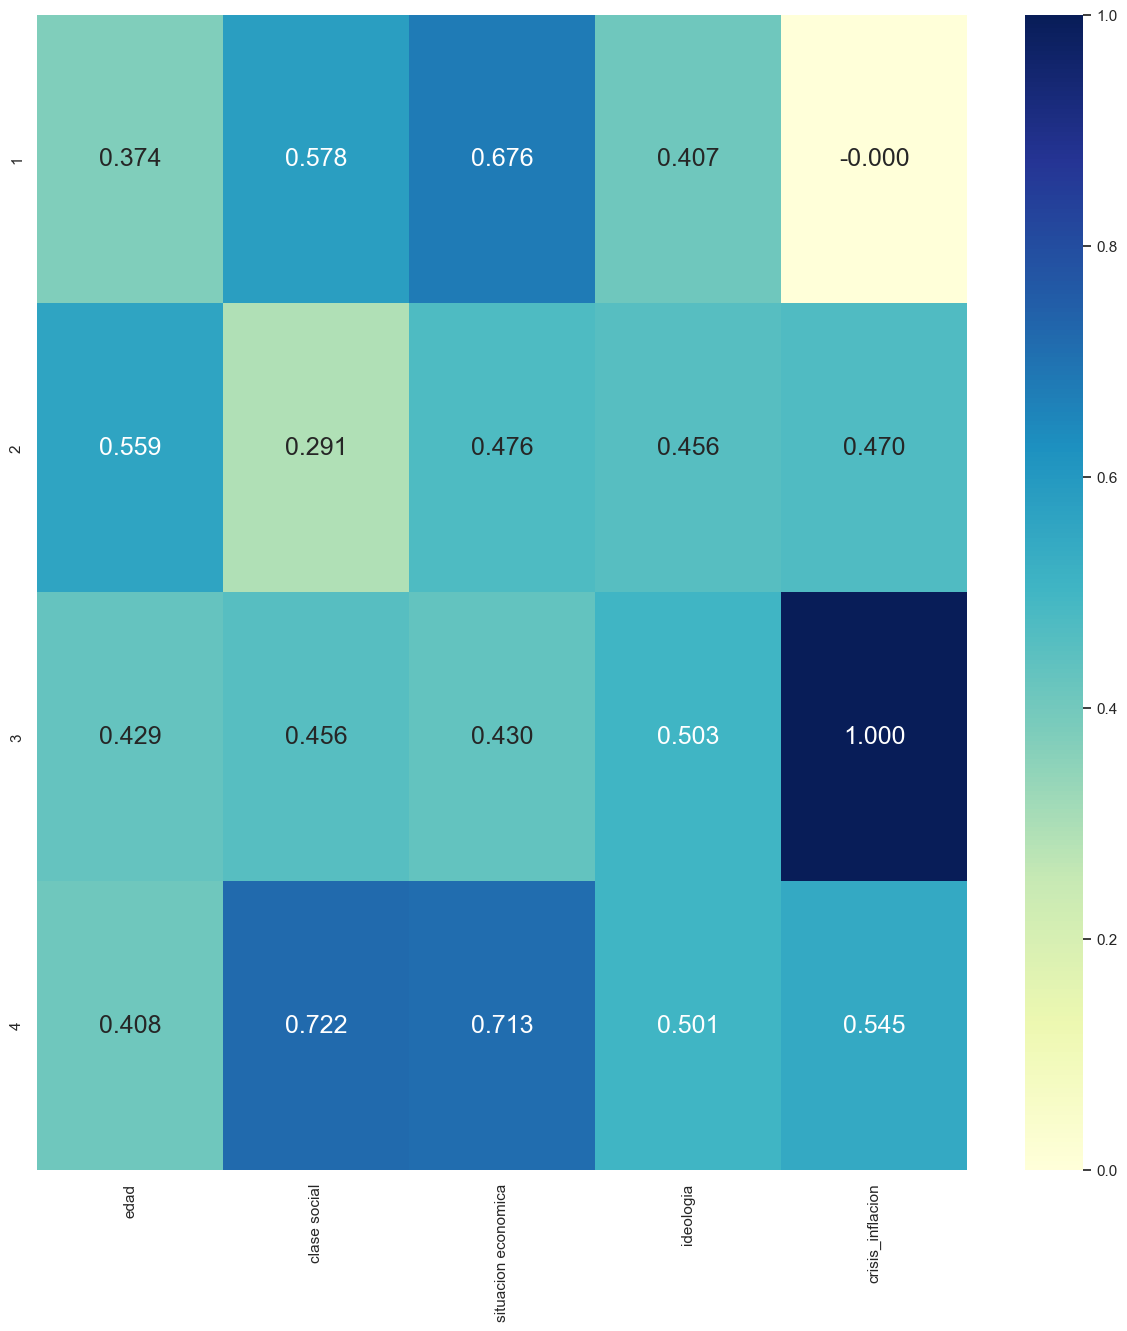

<Figure size 640x480 with 0 Axes>

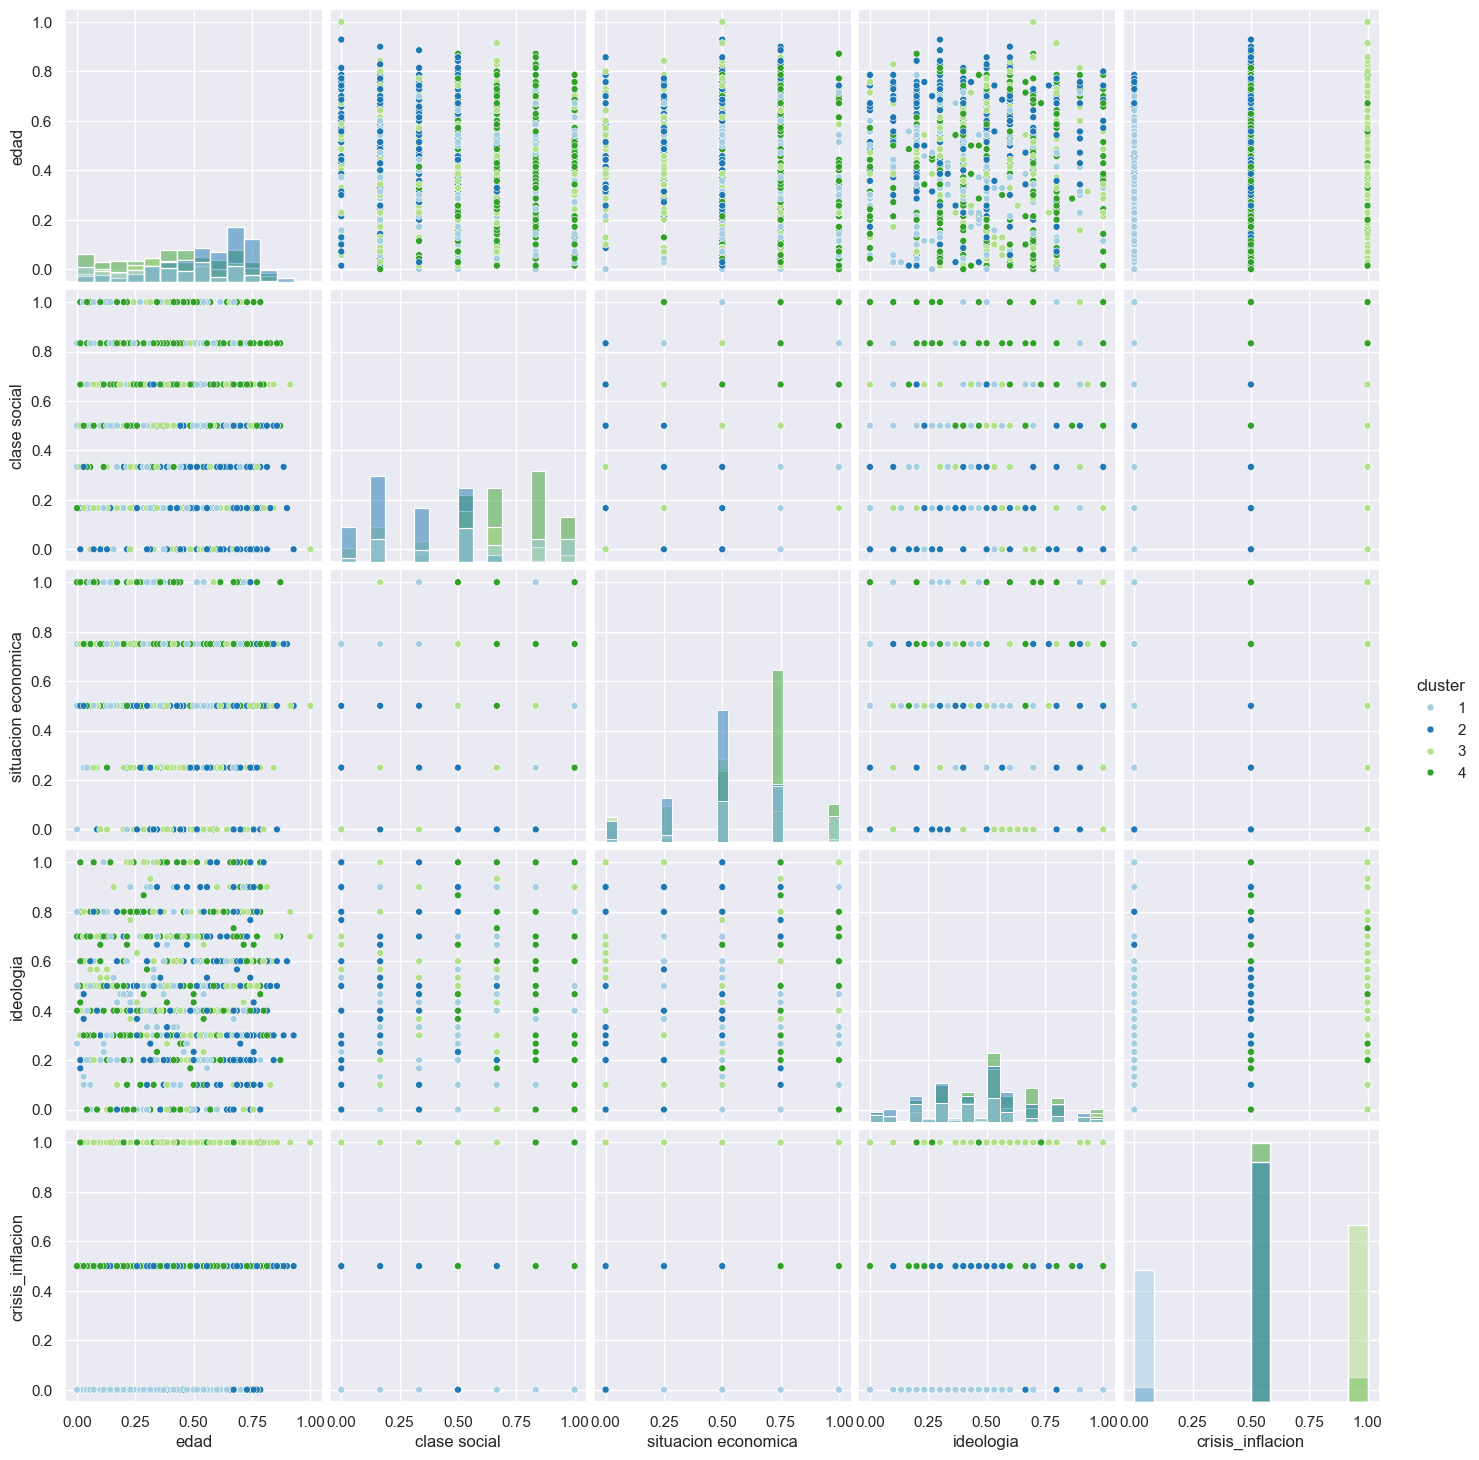

---------- MDS...


C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\manifold\_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


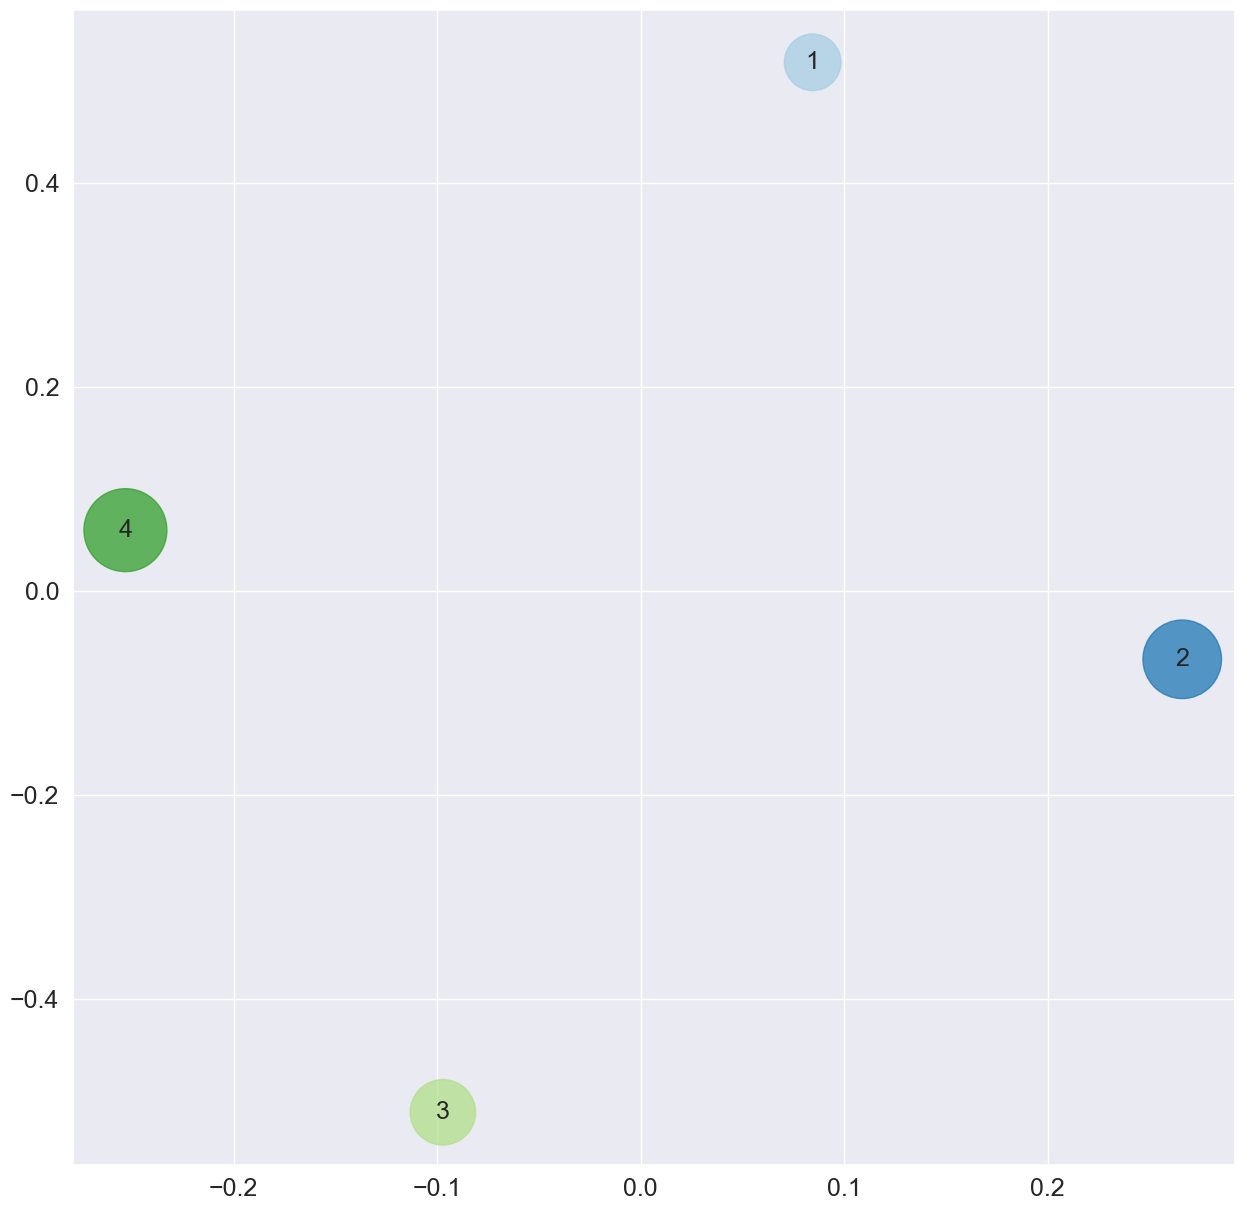

In [14]:
### VISUALIZACIÓN CASO 3 - kmeans
### Ejecutamos algoritmos
algoritmos = ['kmeans']
results_df = pd.DataFrame(columns=['Algoritmo', 'Tiempo (s)', 'Calinski-Harabasz', 'Silhouette', 'Número de clusters']) #Para la tabla

for i in range(0, len(algoritmos)):
    if algoritmos[i] == 'kmeans':
        tiempo, kmeans_resultado, cluster_predict = kmeans(X_normal, subset)
        cluster_kmeans=cluster_predict
        
    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    
    
#1. Gráfico de barras para representar el tamaño de los clusters
tabla_clusters = (
    [{'cluster': 0, 'tamaño': 166},
     {'cluster': 1, 'tamaño': 320},
     {'cluster': 2, 'tamaño': 222},
     {'cluster': 3, 'tamaño': 357},],
    pd.Series({0: 166, 1: 320, 2: 222, 3: 357}, name='count')
)

# Crear un DataFrame a partir de la lista de diccionarios
df = pd.DataFrame(tabla_clusters[0])

# Creamos el gráfico de barras
sns.set(style="whitegrid")
sns.catplot(y="tamaño", x="cluster", data=df, kind="bar", color="skyblue", aspect=2)
plt.show()

#2. Heatmap
heatmap(kmeans_resultado)

#3. Scatter matrix
# se añade la asignación de clusters como columna a X
X_kmeans = pd.concat([X, clusters], axis=1)
k = len(size)
colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
scatter(X_kmeans, colors)

#4. Boxplot
#boxplot(X_kmeans, cluster_kmeans)
#boxplot2(kmeans_resultado, X)

#5. MDS
centers, centers_desnormal = calcular_centros("kmeans", X, kmeans_resultado, cluster_kmeans)
MDS_plot(centers, size)

In [15]:
### CASO DE ESTUDIO 3: Estudio de parámetros en Single Linkage
datos = pd.read_csv('03_Datos_noviembre_2023_num.csv')
peso = 'ponde'
tabla_parametros=[]

#Imputamos los valores perdidos
datos=imputar_valores_perdidos(datos)

# Seleccionar casos, filtrando por sexo
subset = datos.loc[(datos['sexo']==1)] #Sexo=mujer (1=2 después de normalizar :)

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"cs": "clase social", "p1": "situacion economica", "p7": "ideologia",
                              "p9_5": "crisis_inflacion"})
usadas = ['edad', 'clase social','situacion economica', 'ideologia', 'crisis_inflacion']
#print(subset[usadas])


n_var = len(usadas)
X = subset[usadas]

#eliminamos outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
#X=eliminar_outliers(X)

# normalizamos
X_normal = X.apply(norm_to_zero_one)



for i in range(1, 21,2):
    tiempo, single_linkage_resultado, cluster_predict = single_linkage(X_normal, subset, n_clusters_arg=i)
        
    try:
        print("\n\nMedidas\n\n") 
        ch = CH_score(X_normal, cluster_predict)
        sc = SC_score(X_normal, cluster_predict)
    except:
        print("\n\nNo hay medidas :(\n\n") #Cuando sólo hay 1 cluster, no se pueden sacar medidas 

    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    #print(size)
    tamanio_cluster=len(tamano)

    s = "single\_linkage"  + " & "
    s += "{:.3f}".format(i) + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(sc) + " & "
    s += "{:.5f}".format(ch) + " & "
    s += "{:.0f}".format(i) + " \\\\"

    tabla_parametros.append(s)
    
    
tabla_parametros_formato(tabla_parametros, "single_linkage")

----- Ejecutando Single Linkage Hierarchical Clustering: 0.01 segundos, 

Medidas




No hay medidas :(


Tamaño de cada cluster:
0:  1065 (100.00%)
----- Ejecutando Single Linkage Hierarchical Clustering: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 238.259, Silhouette Coefficient: 0.22328
Tamaño de cada cluster:
0:   185 (17.37%)
1:   254 (23.85%)
2:   626 (58.78%)
----- Ejecutando Single Linkage Hierarchical Clustering: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 120.724, Silhouette Coefficient: 0.19047
Tamaño de cada cluster:
0:   184 (17.28%)
1:   253 (23.76%)
2:   626 (58.78%)
3:     1 ( 0.09%)
4:     1 ( 0.09%)
----- Ejecutando Single Linkage Hierarchical Clustering: 0.01 segundos, 

Medidas


Calinski-Harabasz Index: 82.501, Silhouette Coefficient: 0.16885
Tamaño de cada cluster:
0:   626 (58.78%)
1:   253 (23.76%)
2:   181 (17.00%)
3:     1 ( 0.09%)
4:     1 ( 0.09%)
5:     2 ( 0.19%)
6:     1 ( 0.09%)
----- Ejecutando Single Linkage Hierarchical Clustering: 0.0

In [16]:
### CASO DE ESTUDIO 3: Estudio de parámetros en K-means
datos = pd.read_csv('03_Datos_noviembre_2023_num.csv')
peso = 'ponde'
tabla_parametros=[]

#Imputamos los valores perdidos
datos=imputar_valores_perdidos(datos)

# Seleccionar casos, filtrando por sexo
subset = datos.loc[(datos['sexo']==1)] #Sexo=mujer (1=2 después de normalizar :)

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"cs": "clase social", "p1": "situacion economica", "p7": "ideologia",
                              "p9_5": "crisis_inflacion"})
usadas = ['edad', 'clase social','situacion economica', 'ideologia', 'crisis_inflacion']
#print(subset[usadas])


n_var = len(usadas)
X = subset[usadas]

#eliminamos outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
#X=eliminar_outliers(X)

# normalizamos
X_normal = X.apply(norm_to_zero_one)



for i in range(1, 21,2):
    tiempo, kmeans_resultado, cluster_predict = kmeans(X_normal, subset,n_clusters_arg=i )
        
    try:
        print("\n\nMedidas\n\n") 
        ch = CH_score(X_normal, cluster_predict)
        sc = SC_score(X_normal, cluster_predict)
    except:
        print("\n\nNo hay medidas :(\n\n") #Cuando sólo hay 1 cluster, no se pueden sacar medidas 

    # se convierte la asignación de clusters a DataFrame
    clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

    tamano, size=tamano_clusters(clusters)
    #print(size)
    tamanio_cluster=len(tamano)

    s = "kmeans"  + " & "
    s += "{:.3f}".format(i) + " & "
    s += "{:.3f}".format(tiempo) + " & "
    s += "{:.3f}".format(sc) + " & "
    s += "{:.5f}".format(ch)+ " \\\\"

    tabla_parametros.append(s)
    
    
tabla_parametros_formato(tabla_parametros, "kmeans")

----- Ejecutando k-Means: 0.04 segundos, 

Medidas




No hay medidas :(


Tamaño de cada cluster:
0:  1065 (100.00%)
----- Ejecutando k-Means: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 282.505, Silhouette Coefficient: 0.20827
Tamaño de cada cluster:
0:   254 (23.85%)
1:   437 (41.03%)
2:   374 (35.12%)
----- Ejecutando k-Means: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 226.477, 

C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


Silhouette Coefficient: 0.19347
Tamaño de cada cluster:
0:   303 (28.45%)
1:   165 (15.49%)
2:   136 (12.77%)
3:   150 (14.08%)
4:   311 (29.20%)
----- Ejecutando k-Means: 0.05 segundos, 

Medidas


Calinski-Harabasz Index: 205.397, Silhouette Coefficient: 0.18045
Tamaño de cada cluster:
0:   111 (10.42%)
1:   162 (15.21%)
2:   205 (19.25%)
3:   133 (12.49%)
4:   184 (17.28%)
5:   143 (13.43%)
6:   127 (11.92%)
----- Ejecutando k-Means: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 195.346, Silhouette Coefficient: 0.19490
Tamaño de cada cluster:
0:   171 (16.06%)
1:   140 (13.15%)
2:   168 (15.77%)
3:    73 ( 6.85%)
4:   100 ( 9.39%)
5:   103 ( 9.67%)
6:   107 (10.05%)
7:   103 ( 9.67%)
8:   100 ( 9.39%)
----- Ejecutando k-Means

C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


: 0.05 segundos, 

Medidas


Calinski-Harabasz Index: 180.728, Silhouette Coefficient: 0.19264
Tamaño de cada cluster:
0:    81 ( 7.61%)
1:   107 (10.05%)
2:    63 ( 5.92%)
3:   100 ( 9.39%)
4:   128 (12.02%)
5:   116 (10.89%)
6:   128 (12.02%)
7:    59 ( 5.54%)
8:    72 ( 6.76%)
9:   102 ( 9.58%)
10:   109 (10.23%)
----- Ejecutando k-Means: 0.05 segundos, 

Medidas


Calinski-Harabasz Index: 166.356, Silhouette Coefficient: 0.19197
Tamaño de cada cluster:
0:    39 ( 3.66%)
1:   108 (10.14%)
2:    52 ( 4.88%)
3:   132 (12.39%)
4:    56 ( 5.26%)
5:    95 ( 8.92%)
6:    65 ( 6.10%)
7:    80 ( 7.51%)
8:    66 ( 6.20%)
9:    53 ( 4.98%)
10:   113 (10.61%)
11:    75 ( 7.04%)
12:   131 (12.30%)
----- Ejecutando k-Means: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 160.307, Silhouette Coefficient: 0.19516
Tamaño de cada cluster:
0:   102 ( 9.58%)
1:    69 ( 6.48%)
2:    70 ( 6.57%)
3:    82 ( 7.70%)
4:    56 ( 5.26%)
5:   106 ( 9.95%)
6:    76 ( 7.14%)
7:    75 ( 7.04%)
8:    45 ( 4.23

C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 152.254, Silhouette Coefficient: 0.19705
Tamaño de cada cluster:
0:    82 ( 7.70%)
1:    71 ( 6.67%)
2:    62 ( 5.82%)
3:    64 ( 6.01%)
4:    57 ( 5.35%)
5:    92 ( 8.64%)
6:    41 ( 3.85%)
7:    59 ( 5.54%)
8:    45 ( 4.23%)
9:    50 ( 4.69%)
10:    68 ( 6.38%)
11:    59 ( 5.54%)
12:    81 ( 7.61%)
13:    35 ( 3.29%)
14:    43 ( 4.04%)
15:    57 ( 5.35%)
16:    99 ( 9.30%)
----- Ejecutando k-Means: 0.06 segundos, 

Medidas


Calinski-Harabasz Index: 146.487, Silhouette Coefficient: 0.19667
Tamaño de cada cluster:
0:    52 ( 4.88%)
1:    65 ( 6.10%)
2:    48 ( 4.51%)
3:    63 ( 5.92%)
4:    63 ( 5.92%)
5:    48 ( 4.51%)
6:    36 ( 3.38%)
7:    51 ( 4.79%)
8:    47 ( 4.41%)
9:    67 ( 6.29%)
10:    56 ( 5.26%)
11:    60 ( 5.63%)
12:    79 ( 7.42%)
13:    60 ( 5.63%)
14:    76 ( 7.14%)
15:    41 ( 3.85%)
16:    36 ( 3.38%)
17:    51 ( 4.79%)
18:    66 ( 6.20%)
\begin{table}[H]
\centering
\caption{Resultados cambio de parámetros}
\lab

C:\Users\monic\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
